In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 2"

In [2]:
# install dependencies: 
#!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.8.0+cu111 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

In [4]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import json, random
#from google.colab.patches import cv2_imshow
import cv2
from IPython.display import display
from IPython.display import Image as IPyImage
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer as Vis
#import Visualizer as Vis
#from Visualizer import *
from detectron2.data import MetadataCatalog, DatasetCatalog
import importlib
from io import BytesIO
from PIL import Image as PILImage
from matplotlib.pyplot import imshow
import detectron2
import matplotlib.pyplot as plt
from detectron2 import engine
DefaultPredictor = engine.DefaultPredictor
import threading
import multiprocessing
from pprint import pprint
from detectron2.modeling import build_model
import detectron2.data.transforms as T
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data import detection_utils as utils
#from mydataset import MyDataset
from torch.utils.data import DataLoader
import pickle
from collections import Counter, defaultdict
from nltk.corpus import stopwords

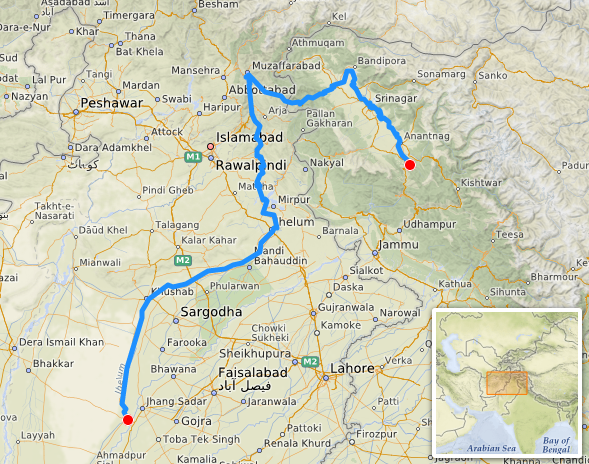

In [13]:
im = PILImage.open("/data/yingshac/MMMHQA/x_distractors/20200001.jpg")
nd = np.array(im)
im

In [11]:
threshold = 0.5
cfg = get_cfg()
config = "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file("/home/yingshac/CYS/WebQnA/RegionFeature/detectron-vlp/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config)
#cfg.MODEL.WEIGHTS = "https://onedrive.live.com/download?cid=E5364FD183A1F5BB&resid=E5364FD183A1F5BB%212014&authkey=AAHgqN3Y-LXcBvU"
cfg.MODEL.WEIGHTS = "/home/yingshac/CYS/WebQnA/RegionFeature/detectron-vlp/e2e_faster_rcnn_X-101-64x4d-FPN_2x-vlp-427.pkl"
#model = build_model(cfg)
#DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS) 
#model = torch.nn.DataParallel(model, device_ids=[0,1]).module

In [36]:
#im_name = random.choice(os.listdir("/data/yingshac/MMMHQA/distractors/"))
im_name = "10117355.jpg" #10308796
#im = PILImage.open(os.path.join("/data/yingshac/MMMHQA/distractors/", im_name)).convert("RGB")
#original_image = np.array(im)

original_image = utils.read_image(os.path.join("/data/yingshac/MMMHQA/distractors/", im_name), format="RGB")
model.eval()
with torch.no_grad():
    #original_image = original_image[:, :, ::-1]
    height, width = original_image.shape[:2]
    aug = T.ResizeShortestEdge([cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST)
    image = aug.get_transform(original_image).apply_image(original_image)
    image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))

    inputs = {"image": image, "height": height, "width": width}
    outputs = model.inference_FE([inputs, inputs])
    

In [38]:
print(type(outputs[0]))

<class 'detectron2.structures.instances.Instances'>


In [6]:
folder = "/data/yingshac/MMMHQA/gold_test/"
abs_paths = [os.path.join(folder, im_name) for im_name in os.listdir(folder)]
dataset = MyDataset(abs_paths, cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MAX_SIZE_TEST)


In [18]:
dataloader = DataLoader(dataset, batch_size=4, num_workers=4, shuffle=False, collate_fn = lambda x: x)
model.eval()
outputs_list = []
im_names_list = []
append = False
with torch.no_grad():
    for batch_idx, item in enumerate(dataloader):
        print(batch_idx)
        inputs = [i[0] for i in item]
        im_names = [i[1] for i in item]
        print(im_names)
        im_names_list.extend(im_names)
        outputs = model.inference_FE(inputs)
        outputs_list.extend(outputs)
        save_RF(im_names_list, outputs_list, "region_features.pkl", append)
        append = True
        outputs_list = []
        im_names_list = []
        if batch_idx>1: break

0
['/data/yingshac/MMMHQA/gold_test/00018049.jpg', '/data/yingshac/MMMHQA/gold_test/00012443.jpg', '/data/yingshac/MMMHQA/gold_test/00006724.jpg', '/data/yingshac/MMMHQA/gold_test/00015766.jpg']
return box_head forward
layer:  Flatten(start_dim=1, end_dim=-1)
layer:  Linear(in_features=25088, out_features=2048, bias=True)
get mid
layer:  ReLU()
layer:  Linear(in_features=2048, out_features=2048, bias=True)
layer:  ReLU()
return box_head partial forward
layer:  Flatten(start_dim=1, end_dim=-1)
layer:  Linear(in_features=25088, out_features=2048, bias=True)
get mid
layer:  ReLU()
layer:  Linear(in_features=2048, out_features=2048, bias=True)
layer:  ReLU()
return box_head partial forward
layer:  Flatten(start_dim=1, end_dim=-1)
layer:  Linear(in_features=25088, out_features=2048, bias=True)
get mid
layer:  ReLU()
layer:  Linear(in_features=2048, out_features=2048, bias=True)
layer:  ReLU()
return box_head partial forward
layer:  Flatten(start_dim=1, end_dim=-1)
layer:  Linear(in_features

In [8]:
def save_RF(im_names_list, outputs_list, filename, append):
    op = 'ab+' if append else 'wb+'
    region_features = {}
    for im_name, output in zip(im_names_list, outputs_list):
        inst = output['instances']
        region_features[os.path.basename(im_name).replace(".jpg", "")] = {"image_size": inst.image_size, "num_instances": len(inst),\
                                                                         "pred_boxes": inst.pred_boxes, "scores": inst.scores, \
                                                                         "pred_classes": inst.pred_classes, \
                                                                          "fc1_features": inst.fc1_features, \
                                                                         "cls_features": inst.cls_features}
    with open("region_features.pkl", op) as fp:
        pickle.dump(region_features,fp)
    


In [74]:
save_RF(im_names_list, outputs_list, "region_features.pkl", True)

In [55]:
with open("region_features.pkl", 'ab') as fp:
    pickle.dump(region_features,fp)
    pickle.dump(region_features,fp)

In [29]:
region_features_reload = {}
count = 0
with open("./Output/region_features_gold.pkl", 'rb') as fr:
    try:
        while count<1:
            count += 1
            region_features_reload.update(pickle.load(fr))
    except EOFError:
        pass
print(len(region_features_reload))

480


In [6]:
print(len(os.listdir("/data/yingshac/MMMHQA/imgFeatures/gold/")))
#sorted(os.listdir("/data/yingshac/MMMHQA/imgFeatures/distractors/"))[97000:]

22265


In [19]:
k='20000031'
with open("/data/yingshac/MMMHQA/imgFeatures_x_distractors/x_distractors/{}.pkl".format(k), 'rb') as fr:
    region_features_reload = pickle.load(fr)

In [127]:
#k = '00020214'
image_size = region_features_reload.pop('image_size')
region_features_reload.pop('num_instances')
inst = detectron2.structures.instances.Instances(image_size, **region_features_reload)

In [128]:
im_name = "/data/yingshac/MMMHQA/x_distractors/" + k + ".jpg"
original_image = utils.read_image(im_name, format="RGB")
v = Visualizer(original_image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(inst.to("cpu"))
pil_im = PILImage.fromarray(out.get_image()[:, :, ::-1])
pil_im

IndexError: list index out of range

In [5]:
predictor = DefaultPredictor(cfg)

[04/28 19:15:59 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[04/28 19:15:59 d2.checkpoint.c2_model_loading]: Remove prediction weight for background class in bbox_pred.bias. The shape changes from (6404,) to (6400,).
[04/28 19:15:59 d2.checkpoint.c2_model_loading]: Remove prediction weight for background class in bbox_pred.weight. The shape changes from (6404, 2048) to (6400, 2048).
[04/28 19:15:59 d2.checkpoint.c2_model_loading]: Move classification weights for background class in cls_score.bias from index 0 to index 1600.
[04/28 19:15:59 d2.checkpoint.c2_model_loading]: Move classification weights for background class in cls_score.weight from index 0 to index 1600.
[04/28 19:15:59 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                 | Shapes                          |
|:------------------------------------------------|:------------------------------------|:---

In [22]:
# We can use `Visualizer` to draw the predictions on the image.
im_name = random.choice(os.listdir("/data/yingshac/MMMHQA/distractors/"))
print(im_name)
im = PILImage.open(os.path.join("/data/yingshac/MMMHQA/distractors/", im_name)).convert("RGB")
im = np.array(im)

ef_outputs = predictor.inference(im)

10134058.jpg
hello


In [133]:
region_features_reload.keys()

dict_keys(['pred_boxes', 'scores', 'pred_classes', 'fc1_features', 'cls_features'])

In [22]:
PILImage.open(os.path.join("/data/yingshac/MMMHQA/x_distractors/", im_name)).convert("RGB").size

(800, 600)

In [24]:
# We can use `Visualizer` to draw the predictions on the image.
#im_name = random.choice(os.listdir("/data/yingshac/MMMHQA/distractors/"))
#im_name = random.choice(list(region_features.keys())) + 'jpg'
im_name = "20000031.jpg"
im = PILImage.open(os.path.join("/data/yingshac/MMMHQA/x_distractors/", im_name)).convert("RGB")
image_size = im.size
im = np.array(im)

#outputs = predictor(im)
outputs = [detectron2.structures.instances.Instances(**region_features_reload)]
#print(outputs['pred_boxes'])
#importlib.reload(Vis)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs)
pil_im = PILImage.fromarray(out.get_image()[:, :, ::-1])
pil_im

TypeError: object of type 'int' has no len()

In [45]:
def count_bbox(folder, im_names, result, received_im = None):
    for i in range(len(im_names)):
        if i % 200 == 199: print("{} bucket, threshold={}, sample_size={}, finish {}/{}".format(args.bucket, args.threshold, args.sample_size, i, len(im_names)))
        im_name = im_names[i]
        if received_im is not None: received_im.append(im_name)
        im = PILImage.open(os.path.join(folder, im_name)).convert("RGB")    
        im = np.array(im)
        outputs = predictor(im)
        result.append(len(outputs['instances'].scores))
    print("return")

In [35]:
def get_names_from_gold(gold_folder = None):
    if gold_folder is not None: return os.listdir(gold_folder)
    return os.listdir("/data/yingshac/MMMHQA/gold_test/")

In [41]:
def get_names_distractor(dataset_json_path = None):
    path = "/home/yingshac/CYS/WebQnA/WebQnA_data/dataset-Copy1.json" if dataset_json_path is None else dataset_json_path
    file = open(path, "r")
    dataset_J = json.load(file)
    file.close()
    return list(set([str(g)+'jpg' for k in dataset_J for g in dataset_J[k]['DistractorIds']]))

In [44]:
# We can use `Visualizer` to draw the predictions on the image.
bucket = 1
all_ims = "/data/yingshac/MMMHQA/gold_test/" if bucket==0 else "/data/yingshac/MMMHQA/distractors/"
sample_size = 3200
num_threads = 32
im_names = random.sample(os.listdir(folder), sample_size)
checkpoints = []
for i in range(num_threads):
    checkpoints.append((i*sample_size//num_threads, (i+1)*sample_size//num_threads))
results = dict((i, []) for i in range(num_threads))
received_ims = dict((i, []) for i in range(num_threads))
threads = []
for i in range(num_threads):
    c = checkpoints[i]
    t = threading.Thread(target=count_bbox, args=(im_names[c[0]:c[1]], results[i], received_ims[i]))
    t.start()
    threads.append(t)
    #count_bbox(im_names[c[0]:c[1]], results[i])
for t in threads:
    t.join()

start
start
start
start
start
start
start
startstart
start

startstart
start

start
start
startstart

start
start
start
start
start
start
start
start
start
start
startstart

start
start
start


KeyboardInterrupt: 

In [34]:
#print(results)
print(len(set([i for v in received_ims.values() for i in v])))
print(np.mean([n for v in results.values() for n in v]))

0
nan


/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


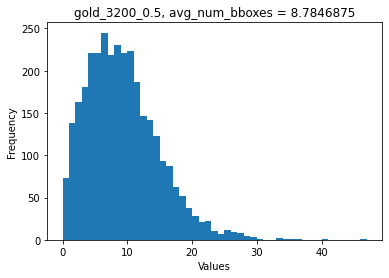

<Figure size 432x288 with 0 Axes>

In [32]:
bucket_name = 'gold' if bucket == 0 else 'distractor'
data = [n for v in results.values() for n in v]
n, bins, patches=plt.hist(data, bins = max(data)-min(data))
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.title('{}_{}_{}, avg_num_bboxes = {}'.format(bucket_name, sample_size, threshold, np.mean(data)))
plt.show()
plt.savefig('{}_{}_{}.jpg'.format(bucket_name, sample_size, threshold))

In [46]:
threshold = 0.5
cfg = get_cfg()
config = "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file("/home/yingshac/CYS/WebQnA/RegionFeature/detectron-vlp/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = float(threshold)  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = "/home/yingshac/CYS/WebQnA/RegionFeature/detectron-vlp/e2e_faster_rcnn_X-101-64x4d-FPN_2x-vlp-427.pkl"
predictor = DefaultPredictor(cfg)

# We can use `Visualizer` to draw the predictions on the image.
bucket = 'gold' #args.bucket.lower()

all_ims = "/data/yingshac/MMMHQA/gold_test/" if bucket=='gold' else "/data/yingshac/MMMHQA/distractors/"
sample_size = 4000 #args.sample_size
num_threads = 32 #args.num_threads
im_names = random.sample(os.listdir(all_ims), sample_size)
checkpoints = []
for i in range(num_threads):
    checkpoints.append((i*sample_size//num_threads, (i+1)*sample_size//num_threads))
results = dict((i, []) for i in range(num_threads))
received_ims = dict((i, []) for i in range(num_threads))
threads = []
for i in range(num_threads):
    c = checkpoints[i]
    t = threading.Thread(target=count_bbox, args=(all_ims, im_names[c[0]:c[1]], results[i], received_ims[i]))
    t.start()
    threads.append(t)
    #count_bbox(im_names[c[0]:c[1]], results[i])
for t in threads:
    t.join()

assert len(set([i for v in received_ims.values() for i in v])) == sample_size
#print(received_ims.values())
data = [n for v in results.values() for n in v]
n, bins, patches=plt.hist(data, bins = max(data)-min(data))
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.title('{}_{}_{}, avg_num_bboxes = {}'.format(bucket, sample_size, threshold, np.mean(data)))
plt.show()

plt.savefig('{}_{}_{}.jpg'.format(bucket, sample_size, threshold))

[04/28 20:41:20 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[04/28 20:41:20 d2.checkpoint.c2_model_loading]: Remove prediction weight for background class in bbox_pred.bias. The shape changes from (6404,) to (6400,).
[04/28 20:41:20 d2.checkpoint.c2_model_loading]: Remove prediction weight for background class in bbox_pred.weight. The shape changes from (6404, 2048) to (6400, 2048).
[04/28 20:41:20 d2.checkpoint.c2_model_loading]: Move classification weights for background class in cls_score.bias from index 0 to index 1600.
[04/28 20:41:20 d2.checkpoint.c2_model_loading]: Move classification weights for background class in cls_score.weight from index 0 to index 1600.
[04/28 20:41:20 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                 | Shapes                          |
|:------------------------------------------------|:------------------------------------|:---

KeyboardInterrupt: 

In [11]:
#print(im_name)
im = cv2.imread(os.path.join(folder, "10029706.jpg"))
print(type(im))
cv2_imshow(im)

<class 'NoneType'>


NameError: name 'cv2_imshow' is not defined

In [166]:
print(outputs['instances'])

Instances(num_instances=12, image_height=1200, image_width=800, fields=[pred_boxes: Boxes(tensor([[  37.1553,    5.8787,  800.0000,  298.7236],
        [ 361.0041,  968.8079,  498.2404, 1171.2029],
        [ 345.7630,  913.6789,  507.1032, 1193.5778],
        [  15.7577,  208.2579,  800.0000, 1200.0000],
        [ 211.5467,  559.5577,  302.0444,  679.6015],
        [ 129.9746,  658.5369,  347.0980,  734.0342],
        [ 529.0677, 1075.6403,  598.0831, 1127.2184],
        [ 206.9528,  823.9233,  302.4140,  990.1008],
        [ 112.6264,  650.2717,  770.4163,  755.3536],
        [ 391.1039,  567.1718,  427.9186,  599.5074],
        [ 412.1770,  970.7963,  453.6086, 1029.9281],
        [ 571.3470,  819.1752,  664.4602,  987.6434]], device='cuda:0')), scores: tensor([0.8738, 0.7880, 0.7728, 0.7551, 0.7309, 0.6989, 0.6981, 0.6392, 0.5811,
        0.5510, 0.5382, 0.5225], device='cuda:0'), pred_classes: tensor([  72,  310,   50,  177,  453, 1507,  128,  453, 1507,  453,   51,  453],
       d

In [50]:
pickle.dump(cpt, open("/home/yingshac/CYS/WebQnA/RegionFeature/detectron-vlp/e2e_faster_rcnn_X-101-64x4d-FPN_2x-vlp-427.pkl", "wb"))

In [37]:
model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")

'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl'

In [39]:
cpt_d2 = pickle.load(open("/home/yingshac/CYS/WebQnA/RegionFeature/detectron-vlp/faster_rcnn_X_101_32x8d_FPN_3x.pkl", "rb"), encoding='latin1')
print(type(cpt_d2))

<class 'dict'>


In [42]:
print(cpt_d2['model'].keys())

odict_keys(['backbone.fpn_lateral2.weight', 'backbone.fpn_lateral2.bias', 'backbone.fpn_output2.weight', 'backbone.fpn_output2.bias', 'backbone.fpn_lateral3.weight', 'backbone.fpn_lateral3.bias', 'backbone.fpn_output3.weight', 'backbone.fpn_output3.bias', 'backbone.fpn_lateral4.weight', 'backbone.fpn_lateral4.bias', 'backbone.fpn_output4.weight', 'backbone.fpn_output4.bias', 'backbone.fpn_lateral5.weight', 'backbone.fpn_lateral5.bias', 'backbone.fpn_output5.weight', 'backbone.fpn_output5.bias', 'backbone.bottom_up.stem.conv1.weight', 'backbone.bottom_up.stem.conv1.norm.weight', 'backbone.bottom_up.stem.conv1.norm.bias', 'backbone.bottom_up.stem.conv1.norm.running_mean', 'backbone.bottom_up.stem.conv1.norm.running_var', 'backbone.bottom_up.res2.0.shortcut.weight', 'backbone.bottom_up.res2.0.shortcut.norm.weight', 'backbone.bottom_up.res2.0.shortcut.norm.bias', 'backbone.bottom_up.res2.0.shortcut.norm.running_mean', 'backbone.bottom_up.res2.0.shortcut.norm.running_var', 'backbone.bottom_

### Reading VLP Code

In [124]:
# Try loading vqa annotations to see the data structure
import numpy as np
img_dat = np.load("/home/yingshac/CYS/WebQnA/vqa2_annotations/vqa/imdb_minival2014.npy", allow_pickle=True)

In [125]:
print(len(img_dat))

65989


In [126]:
print(img_dat[0])
print(img_dat[1])

{'create_time': '2018-04-18 13:01', 'dataset_name': 'vqa', 'version': 1, 'has_answer': True, 'has_gt_layout': False, 'created_at': <built-in function time>}
{'image_name': 'COCO_val2014_000000262162', 'image_id': 262162, 'question_id': 262162000, 'feature_path': 'COCO_val2014_000000262162.npy', 'question_str': 'Is that a folding chair?', 'question_tokens': ['is', 'that', 'a', 'folding', 'chair'], 'all_answers': ['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no'], 'ocr_tokens': [], 'answers': ['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no']}


### Write Dataset class

In [2]:
from transformers import BertTokenizer, BertModel

model = BertModel.from_pretrained('bert-base-cased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
text_a = tokenizer.tokenize("Hi!")
text_b = tokenizer.tokenize("Hello!")
text_c = tokenizer.tokenize("Morning!")
tokenized_text = ["[CLS]"] + text_a + ["[SEP]"] + text_b + ["[SEP]"] + text_c + ["[SEP]"]

# Tokenize our sentence with the BERT tokenizer.
#tokenized_text = tokenizer.tokenize(marked_text)
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
segments_ids = [0] * (2+len(text_a)) + [1] * (1+len(text_b)) + [2] * (1+len(text_c)) 
    
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])
with torch.no_grad():
    outputs = model(tokens_tensor, segments_tensors)
        # becase we set `output_hidden_states = True`, the third item will be the hidden states from all layers. 
    hidden_states = outputs[2]

In [206]:
os.path.exists("/data/yingshac/MMMHQA/imgFeatures/distractors/10000000.pkl")

True

In [46]:
with open("/home/yingshac/CYS/WebQnA/WebQnA_data/img_metadata-Copy1.json", "r") as f:
    img_meta = json.load(f)
print(len(img_meta))

362367


In [188]:
tokenizer.tokenize('"What is your name?"')

['"', 'what', 'is', 'your', 'name', '?', '"']

In [327]:
dataset_J_uninfo_meta = {}
for j in dataset_J:
    q = dataset_J[j]['Q'].lower().replace('"', "").strip()
    q = tokenizer.tokenize(q)
    meta = []
    for im in dataset_J[j]['GoldIds']:
        k = str(int(im))
        m = (img_meta[k]['name'] + img_meta[k]['description']).replace("_", " ").strip().lower()
        meta += tokenizer.tokenize(m)
    if len([w for w in q if w in meta]) < 1:
        dataset_J_uninfo_meta[j] = dataset_J[j]
print(len(dataset_J_uninfo_meta))
#with open("/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/uninfo_meta.json", "w") as f:
 #   json.dump(dataset_J_uninfo_meta, f, indent=4)

668


In [302]:
id_list = []
for k in img_meta:
    if int(k) < 10000000:
        meta= img_meta[k]['name'] + img_meta[k]['description']
        if len([i for i in meta if not i.isdigit()]) < 15:
            print(meta)
            id_list.append(k)
print(len(id_list))

Disco_H2O_6
Bubba_Tub_5
Quatro_(3568217777)
McDonalds
London_2390.JPG
London_2372.JPG
Memchu_organ2
Stata_Center-20050310-2
ISH_WC_Boston6
FDR
Boston5808.JPG
Shamrock_Run_2010
Hogwarts_(29353863945)
Hogsmeade_(29275520211)
Hogsmeade_(29320854486)
Nathansgadv
Papaya_Dog_(12686826784)
The_Mirage_(5940994263)
CostcoMontreal
WardenT&T.JPG
HarvardStadium2
Club_33_2013_15.JPG
Club_33_2013_23.JPG
CHGO-650_(7132399805)
Club_33_2013_11.JPG
DSC_0126_(2560113530)
Wingspread_2
Uoft_pharmacy
DSC_0114_(2559287915)
CNN_(8215301993)
Monkey_Statue
Lounge_(35275606).jpeg
Reflection_(9649859788)
Down_the_block
Broadway_(9075158922)
London_(182598435).jpeg
Usforces
New_York_City11
Broadway_(9072763327)
Mockingjay_(15470344510)
(2005)_RaiNY_(5691664789)
SF_(4516791491)
SF_(4516792493)
Music_Hall
Lake_Eola-1
The_Bomb_Bay_2
MarchBigBeanie
3089LakeshoreRabba
FoodBasics
OPG_Bldg
CityPlaceRabba
303_East_Wacker
SkyView_ATL
MCW_Metroliner
PittCampus
Fountain_(206316047)
Paramount_(29529567215)
VanWinkle1
05_Finic

Sopransaksofon
SoraSDyg1
Baggensgatan3
SisanteSiega
Grant_Hill_2007-12-08
LouvreArche
METAXADES
Józef_Szmidt_1964
BhutliddCRW_4351
Café_Josty
Rockweekend2010
Mundorgel
VenusFort-3
Klikli
KumanomiKama
1516


In [620]:
with open("/home/yingshac/CYS/WebQnA/WebQnA_data/dataset_J0501-Copy1.json", "r") as f:
    dataset_J = json.load(f)
pprint(dataset_J["0"])

{'A': '"Lilypads"',
 'DistractorIds': ['10340070',
                   '10340074',
                   '10340071',
                   '10340081',
                   '10340079',
                   '10340076',
                   '10340072',
                   '10000012',
                   '10340077',
                   '10340078',
                   '10042513',
                   '10000000',
                   '10340075',
                   '10000004',
                   '10000003',
                   '10000008',
                   '10000002',
                   '10000001',
                   '10000006',
                   '10340080',
                   '10000019',
                   '10340073'],
 'GoldIds': ['00000000'],
 'Q': '"What is floating in the pond around Bethesda Fountain?"',
 'Qtype': 'img-Singlehop',
 'split': 'train',
 'topic': 'Other'}


In [569]:
print(len([j for j in dataset_J if len(dataset_J[j]['GoldIds']) == 2]))
print(len([j for j in dataset_J if dataset_J[j]['Qtype'] == 'img-Multihop']))

11383
9446


In [3]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [509]:
print(Counter([len(new_txt_json[j]['DistractorFacts']) for j in new_txt_json]))

Counter({5: 1618, 6: 1409, 7: 1019, 8: 627, 4: 615, 9: 400, 2: 272, 10: 250, 3: 220, 11: 187, 12: 124, 14: 74, 13: 73, 15: 35, 16: 34, 19: 31, 18: 30, 17: 26, 20: 12, 1: 8, 21: 7, 23: 6, 22: 4, 25: 2, 24: 2, 31: 2, 27: 2})


In [568]:
print(Counter([len(new_txt_json[j]['SupportingFacts']) for j in new_txt_json]))

Counter({2: 7646, 3: 245, 4: 19, 0: 11})


In [202]:
print(Counter([len(dataset_J[j]['DistractorIds']) for j in dataset_J]))

Counter({22: 10141, 44: 4848, 21: 1306, 43: 1273, 13: 805, 42: 802, 35: 765, 40: 751, 41: 678, 18: 601, 20: 515, 19: 402, 39: 384, 38: 266, 34: 226, 37: 193, 17: 177, 36: 173, 33: 145, 31: 120, 12: 104, 16: 104, 32: 102, 15: 85, 14: 79, 26: 76, 30: 71, 11: 70, 29: 68, 28: 43, 25: 27, 27: 25, 23: 15, 7: 15, 24: 10, 10: 4, 8: 3, 9: 2})


In [652]:
print(Counter([len(dataset_J_nonbinary[j]['GoldIds']) for j in dataset_J_nonbinary]))

Counter({1: 10721, 2: 6052})


In [626]:
for k in dataset_J_fix_dis:
    dataset_J_fix_dis[k]['GoldIds'] = dataset_J[k]['GoldIds']
    assert set(dataset_J_fix_dis[k]['DistractorIds']) == set(dataset_J[k]['DistractorIds'])
    assert dataset_J_fix_dis[k]['Q'] == dataset_J[k]['Q']
    assert dataset_J_fix_dis[k]['A'] == dataset_J[k]['A']
    assert dataset_J_fix_dis[k]['split'] == dataset_J[k]['split']
    assert dataset_J_fix_dis[k]['Qtype'] == dataset_J[k]['Qtype']
    assert dataset_J_fix_dis[k]['topic'] == dataset_J[k]['topic']


In [635]:
f = open("/home/yingshac/CYS/WebQnA/WebQnA_data/dataset_J0529-Copy1.json", "w")
f.close()
    #json.dump(dataset_J_fix_dis, f, indent=4)

PermissionError: [Errno 13] Permission denied: '/home/yingshac/CYS/WebQnA/WebQnA_data/dataset_J0529-Copy1.json'

In [596]:
print(Counter([len(tokenizer.tokenize(dataset_J_fix_dis[j]['A'])) for j in dataset_J_fix_dis]))

Counter({3: 11604, 4: 5449, 5: 2508, 6: 1644, 7: 1036, 8: 813, 9: 735, 10: 479, 11: 354, 12: 251, 13: 166, 14: 112, 15: 70, 16: 67, 17: 37, 18: 30, 19: 29, 21: 15, 22: 15, 20: 12, 23: 9, 24: 8, 27: 6, 25: 5, 28: 5, 26: 4, 29: 3, 33: 3, 30: 2, 32: 1, 31: 1, 42: 1})


In [354]:
print(Counter([len(dataset_J[j]['DistractorIds']) for j in dataset_J if not dataset_J[j]['split'] == 'train']))

Counter({22: 3104, 44: 1469, 21: 388, 43: 375, 13: 252, 35: 241, 40: 229, 42: 218, 18: 188, 41: 187, 20: 148, 39: 110, 19: 106, 38: 77, 36: 60, 17: 58, 34: 53, 37: 52, 33: 44, 31: 34, 12: 33, 32: 30, 29: 27, 15: 26, 16: 26, 14: 21, 30: 20, 11: 18, 26: 16, 28: 14, 27: 9, 7: 6, 25: 6, 24: 5, 23: 2, 9: 2, 10: 1})


In [599]:
segment_b_len_list = []
long_sample_ids = []
for k in dataset_J_fix_dis:
    l = normalize_text(dataset_J_fix_dis[k]['A'].replace('"', ''))
    if len(l) == 0:
        print(dataset_J_fix_dis[k])
    segment_b_len_list.append(len(l))
c = Counter(segment_b_len_list)
print(sorted(c.items(), key=lambda x:x[0], reverse=True))

{'Q': '"Which word on the sign for The Pavilion End on Watling Street is smaller than the others?"', 'A': '"the"', 'Qtype': 'img-Singlehop', 'GoldIds': ['00002706'], 'DistractorIds': ['10044845', '10044847', '10044844', '10029894', '10044843', '10044851', '10044849', '10044859', '10044848', '10044853', '10044846', '10000658', '10044856', '10000663', '10044852', '10026248', '10044855', '10044850', '10044858', '10044854', '10000657', '10044857'], 'topic': 'world expo pavilion', 'split': 'train'}
{'Q': '"Which SBK Line Bukit Bintang Entrance is wider, E or A?"', 'A': '"A"', 'Qtype': 'img-Multihop', 'GoldIds': ['00009001', '00014023'], 'DistractorIds': ['10180398', '10228316', '00008180', '10169538', '10153127', '10029133', '00014059', '10153129', '10153116', '10228317', '10153118', '10153128', '10228324', '10153124', '10228322', '10228320', '10153098', '10153122', '10153130', '10005495', '10153113', '10228318', '10228319', '10074619', '10228321', '10153125', '10153117', '10153101', '10228

In [513]:
a_len_list = []
for k in dataset_J:
    l = len(tokenizer.tokenize(dataset_J[k]['A']))
    a_len_list.append(l)

c = Counter(a_len_list)
print(sorted(c.items(), key=lambda x:x[0], reverse=True))

[(42, 1), (33, 3), (32, 1), (31, 1), (30, 2), (29, 3), (28, 5), (27, 6), (26, 4), (25, 5), (24, 8), (23, 9), (22, 15), (21, 15), (20, 12), (19, 29), (18, 30), (17, 37), (16, 67), (15, 70), (14, 112), (13, 166), (12, 251), (11, 354), (10, 479), (9, 735), (8, 813), (7, 1036), (6, 1644), (5, 2508), (4, 5449), (3, 11604)]


In [565]:
a_len_list = []
for k in new_txt_json:
    if new_txt_json[k]['split'] == 'train':
        l = len(tokenizer.tokenize(new_txt_json[k]['A']) + tokenizer.tokenize(new_txt_json[k]['Q']))
        a_len_list.append(l)

c = Counter(a_len_list)
print(sorted(c.items(), key=lambda x:x[0], reverse=True))

[(108, 1), (105, 2), (102, 1), (98, 1), (90, 1), (89, 1), (86, 1), (85, 1), (84, 1), (83, 3), (82, 1), (81, 3), (80, 2), (79, 1), (78, 3), (77, 3), (76, 3), (75, 1), (73, 1), (72, 3), (71, 4), (70, 9), (69, 5), (68, 8), (67, 7), (66, 12), (65, 10), (64, 18), (63, 10), (62, 13), (61, 18), (60, 12), (59, 21), (58, 22), (57, 33), (56, 38), (55, 43), (54, 25), (53, 31), (52, 40), (51, 42), (50, 52), (49, 41), (48, 51), (47, 68), (46, 71), (45, 90), (44, 106), (43, 89), (42, 99), (41, 103), (40, 117), (39, 139), (38, 137), (37, 130), (36, 160), (35, 178), (34, 166), (33, 149), (32, 148), (31, 187), (30, 207), (29, 186), (28, 197), (27, 194), (26, 229), (25, 191), (24, 203), (23, 203), (22, 191), (21, 191), (20, 156), (19, 127), (18, 122), (17, 118), (16, 89), (15, 66), (14, 56), (13, 32), (12, 26), (11, 7), (10, 6), (9, 1)]


In [512]:
a_len_list = []
q_len_list = []
q_plus_a_len_list = []
for k in new_txt_json:
    l1 = len(tokenizer.tokenize(new_txt_json[k]['Q']))
    l2 = len(tokenizer.tokenize(new_txt_json[k]['A']))
    q_len_list.append(l1)
    a_len_list.append(l2)
    q_plus_a_len_list.append(l1 + l2)

c = Counter(q_len_list)
print(sorted(c.items(), key=lambda x:x[0], reverse=True))
print('\n')
c = Counter(a_len_list)
print(sorted(c.items(), key=lambda x:x[0], reverse=True))
print('\n')
c = Counter(q_plus_a_len_list)
print(sorted(c.items(), key=lambda x:x[0], reverse=True))

[(92, 1), (85, 1), (70, 1), (68, 1), (66, 2), (65, 2), (64, 2), (63, 1), (62, 1), (60, 1), (59, 3), (58, 1), (57, 3), (56, 1), (55, 5), (54, 6), (53, 3), (52, 2), (51, 2), (50, 5), (49, 4), (48, 8), (47, 6), (46, 12), (45, 9), (44, 17), (43, 14), (42, 25), (41, 27), (40, 23), (39, 28), (38, 46), (37, 57), (36, 47), (35, 90), (34, 71), (33, 109), (32, 115), (31, 127), (30, 165), (29, 185), (28, 208), (27, 237), (26, 265), (25, 323), (24, 305), (23, 376), (22, 417), (21, 413), (20, 411), (19, 428), (18, 418), (17, 423), (16, 356), (15, 312), (14, 285), (13, 249), (12, 159), (11, 127), (10, 80), (9, 42), (8, 13), (7, 11), (6, 2)]


[(85, 2), (72, 1), (71, 1), (70, 1), (69, 1), (66, 2), (65, 1), (64, 1), (63, 2), (61, 1), (59, 2), (58, 2), (57, 1), (54, 3), (51, 1), (50, 2), (49, 1), (48, 2), (47, 9), (46, 7), (45, 4), (44, 2), (43, 6), (42, 6), (41, 9), (40, 15), (39, 11), (38, 10), (37, 15), (36, 19), (35, 23), (34, 26), (33, 35), (32, 27), (31, 33), (30, 54), (29, 66), (28, 66), (27, 73

In [354]:
for k in long_sample_ids:
    l = len(tokenizer.tokenize(dataset_J[k]['Q']) + tokenizer.tokenize(dataset_J[k]['A']))
    if l>109:
        print(dataset_J[k])

{'Q': '"Which appears to be more in tact: Decorative wall tile with a knob, geometric and floral patterns, 883-859 BCE. From Assur, Iraq. Pergamon Museum, Berlin, Germany or Decorative wall tile with a knob, geometric and floral patterns, inscription of Ashurnasirpal II, 883-859 BCE. From Assur, Iraq. Pergamon Museum, Berlin, Germany?"', 'A': '"Decorative wall tile with a knob, geometric and floral patterns, inscription of Ashurnasirpal II"', 'Qtype': 'img-Multihop', 'GoldIds': ['00014383', '00014384'], 'DistractorIds': ['10233394', '10233421', '10233403', '10233409', '10233414', '10205664', '10233415', '10160098', '10233405', '10233399', '10233398', '10233407', '10233400', '10233406', '10079308', '10233397', '10045097', '10233408', '10233412', '10233404', '10233392', '10233413', '10233396', '10233393', '00003189', '10233411', '10160093', '10233416', '10233395', '10233402', '10045091', '10233420', '10233410', '10233401', '10160104', '10233391', '10233422', '10205663', '10233419', '1023

In [653]:
dataset_J_nonbinary = {}
dataset_J_yes_no = {}
for j in dataset_J:
    if "yes" not in dataset_J_fix_dis[j]['A'].lower() and "no" not in dataset_J_fix_dis[j]['A'].lower():
        dataset_J_nonbinary[j] = dataset_J_fix_dis[j]
    else:
        dataset_J_yes_no[j] = dataset_J_fix_dis[j]
print(len(dataset_J_nonbinary))
print(len(dataset_J_yes_no))
#with open("/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/tmp_jsons/img_nonbinary.json", "w") as f:
 #   json.dump(dataset_J_nonbinary, f, indent=4)
#with open("/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/tmp_jsons/img_yes_no.json", "w") as f:
 #   json.dump(dataset_J_yes_no, f, indent=4)

16773
8701


In [655]:
print(len([j for j in dataset_J_nonbinary if dataset_J_nonbinary[j]['split'] in ['ind_test', 'ood_test']]))
print(len([j for j in dataset_J_yes_no if dataset_J_yes_no[j]['split'] in ['ind_test', 'ood_test']]))

3477
1637


In [495]:
dataset_J_nonbinary = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/img_nonbinary.json", "r"))
dataset_J_yes_no = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/img_yes_no.json", "r"))

print(Counter([len(dataset_J_yes_no[j]['GoldIds']) for j in dataset_J_yes_no]))
print(Counter([len(dataset_J_nonbinary[j]['GoldIds']) for j in dataset_J_nonbinary]))

Counter({2: 5082, 1: 3619})
Counter({1: 10721, 2: 6052})


In [730]:
dataset_J_1gold = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/img_1gold.json", "r"))
dataset_J_2golds = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/img_2golds.json", "r"))
dataset_J_img_multihop = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/dataset_J_img_multihop.json", "r"))

print(Counter([len(dataset_J_1gold[j]['GoldIds']) for j in dataset_J_1gold]))
print(Counter([len(dataset_J_2golds[j]['GoldIds']) for j in dataset_J_2golds]))
print(Counter([len(dataset_J_img_multihop[j]['GoldIds']) for j in dataset_J_img_multihop]))

Counter({1: 14340})
Counter({2: 11134})
Counter({2: 9444, 1: 2})


In [825]:
len([i for i in dataset_J_fix_dis if dataset_J_fix_dis[i]['split'] == 'ind_test'])

2571

In [641]:
dataset_J_1gold = {}
dataset_J_2golds = {}
dataset_J_img_multihop = {}
for j in dataset_J_fix_dis:
    if len(dataset_J_fix_dis[j]['GoldIds']) == 1:
        dataset_J_1gold[j] = dataset_J_fix_dis[j]
    elif len(dataset_J_fix_dis[j]['GoldIds']) == 2:
        dataset_J_2golds[j] = dataset_J_fix_dis[j]
    else:
        print(len(dataset_J_fix_dis[j]['GoldIds']))
    if dataset_J_fix_dis[j]['Qtype'] == "img-Multihop":
        dataset_J_img_multihop[j] = dataset_J_fix_dis[j]
print(len(dataset_J_1gold))
print(len(dataset_J_2golds))
print(len(dataset_J_img_multihop))
#with open("/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/tmp_jsons/img_1gold.json", "w") as f:
#    json.dump(dataset_J_1gold, f, indent=4)
#with open("/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/tmp_jsons/img_2golds.json", "w") as f:
#    json.dump(dataset_J_2golds, f, indent=4)
#with open("/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/tmp_jsons/dataset_J_img_multihop.json", "w") as f:
#    json.dump(dataset_J_img_multihop, f, indent=4)

14340
11134
9446


In [643]:
print(len([j for j in dataset_J_1gold if dataset_J_1gold[j]['split'] in ['ind_test', 'ood_test']]))
print(len([j for j in dataset_J_2golds if dataset_J_2golds[j]['split'] in ['ind_test', 'ood_test']]))
print(len([j for j in dataset_J_img_multihop if dataset_J_img_multihop[j]['split'] in ['ind_test', 'ood_test']]))

2927
2187
1936


In [348]:
long_data = {}
for k in long_sample_ids:
    long_data[k] = dataset_J[k].copy()

In [352]:
with open("/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/long_data.json", "r") as f:
    tmp = json.load(f)
    #json.dump(long_data, f, indent=4)
print(len(tmp))
print(tmp)

10
{'2533': {'Q': '"Which is under a rounded dome; Holy Family Catholic Church (Columbus, Ohio) - interior, tabernacle (Laetare Sunday) altar, and reredos depicting the Transfiguration or  Immaculate Conception Catholic Church (Celina, Ohio) - interior, tabernacle and Sacred Heart of Jesus statue?"', 'A': '"Immaculate Conception Catholic Church (Celina, Ohio) - interior, tabernacle and Sacred Heart of Jesus statue"', 'Qtype': 'img-Multihop', 'GoldIds': ['00002865', '00002866'], 'DistractorIds': ['10047915', '10047947', '10047941', '10047928', '10047914', '10047922', '10047948', '10047945', '10047907', '10047929', '10047911', '10047931', '10047942', '10047943', '10047926', '10047916', '10047924', '10047932', '10047919', '10029725', '10047936', '10047917', '10047923', '10047921', '10047927', '10047935', '10047930', '10047918', '10047944', '10047940', '10047920', '10047937', '10047909', '10047934', '10047946', '10047939', '10047912', '10047933', '10047938', '10047910', '10029714', '100479

In [212]:
segment_len_list = []
for k in dataset_J:
    l = len(tokenizer.tokenize(dataset_J[k]['Q'])) # + tokenizer.tokenize(dataset_J[k]['A'])
    segment_len_list.append(l)
c = Counter(segment_len_list)
print(sorted(c.items(), key=lambda x:x[0], reverse=True))

[(97, 1), (94, 1), (85, 1), (81, 1), (78, 1), (71, 2), (70, 1), (69, 4), (68, 1), (67, 3), (66, 2), (65, 2), (64, 5), (63, 2), (62, 2), (61, 6), (60, 3), (59, 5), (58, 9), (57, 11), (56, 8), (55, 18), (54, 16), (53, 8), (52, 19), (51, 22), (50, 32), (49, 24), (48, 40), (47, 37), (46, 47), (45, 46), (44, 63), (43, 88), (42, 83), (41, 117), (40, 116), (39, 170), (38, 173), (37, 217), (36, 250), (35, 348), (34, 381), (33, 459), (32, 507), (31, 592), (30, 666), (29, 822), (28, 874), (27, 995), (26, 1165), (25, 1234), (24, 1371), (23, 1391), (22, 1554), (21, 1595), (20, 1618), (19, 1603), (18, 1478), (17, 1277), (16, 1196), (15, 983), (14, 719), (13, 485), (12, 305), (11, 128), (10, 54), (9, 13), (8, 4)]


In [213]:
segment_len_list = []
for k in dataset_J:
    l = len(tokenizer.tokenize(dataset_J[k]['A'])) # + tokenizer.tokenize(dataset_J[k]['A'])
    segment_len_list.append(l)
c = Counter(segment_len_list)
print(sorted(c.items(), key=lambda x:x[0], reverse=True))

[(42, 1), (33, 3), (32, 1), (31, 1), (30, 2), (29, 3), (28, 5), (27, 6), (26, 4), (25, 5), (24, 8), (23, 9), (22, 15), (21, 15), (20, 12), (19, 29), (18, 30), (17, 37), (16, 67), (15, 70), (14, 112), (13, 166), (12, 251), (11, 354), (10, 479), (9, 735), (8, 813), (7, 1036), (6, 1644), (5, 2508), (4, 5449), (3, 11604)]


In [303]:
print(id_list[:10])
print(type(id_list[0]))

['4', '6', '9', '18', '29', '32', '64', '71', '78', '94']
<class 'str'>


In [307]:
j_list = []
for j in dataset_J:
    datum = dataset_J[j]
    for im in datum['GoldIds']:
        if str(int(im)) in id_list:
            j_list.append(j)
print(len(set(j_list)))
dataset_J_uninfo_meta = {}
for j in dataset_J:
    if j in j_list:
        dataset_J_uninfo_meta[j] = dataset_J[j]
print(len(dataset_J_uninfo_meta))
#with open("/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/uninfo_meta.json", "w") as f:
#    json.dump(dataset_J_uninfo_meta, f, indent=4)

2326
2326


In [326]:
j = random.sample(dataset_J_uninfo_meta.keys(), 1)[0]
print(j)
#j='20227'
datum = dataset_J[j]
print("Q: ", datum['Q'])
print("\n ------------------ Gold meta: ------------------")
for im in datum['GoldIds']:
    img_meta_key = str(int(im))
    cxt = img_meta[img_meta_key]["name"] + img_meta[img_meta_key]["description"]
    print(cxt.replace("_", " ").strip())
print("\n ------------------ Distractor meta: ------------------")
for im in datum['DistractorIds']:
    img_meta_key = str(int(im))
    cxt = img_meta[img_meta_key]["name"] + img_meta[img_meta_key]["description"]
    print(cxt.replace("_", " ").strip())

8491
Q:  "What colors does the lighting of the House of Blues Boston projecting sign emit?"

 ------------------ Gold meta: ------------------
HouseOfBluesBostonMA

 ------------------ Distractor meta: ------------------
Zhongshan, Guangdong, China - panoramio (14)
Altamira 2013 008.JPG
Alviks Torn, landmärke från tunnelbanan, 2016d
Budynek szpitala Ruda Śląska, ul. 1 Maja 279 (5) KS.JPG
House of Blues.JPG
Changjiang, Jingdezhen, Jiangxi, China - panoramio (33)
Málaga-María Zambrano Station
Times Square Taxi (4579822816)
Auramar Beach Hotel Albufeira 5 March 2015.JPG
Night in Neo 19, Taipei City 20100409
First London bus DMC41539 Dennis Dart SLF Caetano Nimbus LK53FDY in Ickenham, Hillingdon, London 16 December 2008
PerthAirport 2005 SeanMcClean
World Food Prize Hall of Laureates remodeling.JPG


In [313]:
with open("/data/yingshac/MMMHQA/imgFeatures_upd/gold/00000000.pkl", "rb") as f:
    feat = pickle.load(f)
#print(feat)
#print(type(feat['fc1_features']))
#print(type(feat['cls_features']))
#print(feat.keys())

In [318]:
print(feat['fc1_features'].detach().cpu())


tensor([[  4.6652,  -2.7518,   5.6746,  ...,  -5.4363,   1.4304,  10.9959],
        [  9.1867,  -0.7274,   4.2559,  ...,  -5.9934,  -0.1215,   2.9070],
        [  3.3118,  -4.1519,  -2.3694,  ...,  -4.5509,  -2.2792,  -4.2293],
        ...,
        [ -6.0772,  -1.6450,  -4.3508,  ...,  -7.8893,  -1.8848,  -3.0481],
        [ 18.7353,   4.3724,  -5.7358,  ...,   0.5735,   4.6725,  -1.4423],
        [ -2.2864,   2.9457,   4.6604,  ..., -12.8313,   5.4913,  -5.9088]])


In [262]:
x = torch.zeros((4, 5, 2))
x[torch.tensor([0,2]), 1:3, :] = torch.ones((4,5,2))[[0,2], 1:3, :]
print(x)

tensor([[[0., 0.],
         [1., 1.],
         [1., 1.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [1., 1.],
         [1., 1.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]])


In [221]:
x = torch.tensor([False, True, False], dtype=torch.long)
print(x)

tensor([0, 1, 0])


In [52]:
prediction = torch.randn((8, 5))
prediction[1][1] = - 200000.0
logs_prediction = torch.nn.functional.log_softmax(prediction, dim=-1)
print(logs_prediction)
#label = torch.randint(5,(8,), dtype=torch.long)
label = torch.ones((8,), dtype=torch.long)
print("label = ", label)
print(prediction.size())
print(label.size())
CEloss = torch.nn.CrossEntropyLoss(reduction='none')
loss = CEloss(prediction, label)
print(loss)

tensor([[-3.4236e+00, -2.1460e+00, -1.7089e+00, -5.9553e-01, -2.1361e+00],
        [-7.7931e-01, -2.0000e+05, -9.2124e-01, -2.6788e+00, -2.5955e+00],
        [-1.8386e+00, -3.2734e-01, -3.9398e+00, -2.7479e+00, -3.3073e+00],
        [-2.5070e+00, -2.5557e+00, -1.4277e+00, -1.9673e+00, -7.7406e-01],
        [-2.5068e+00, -2.2249e+00, -7.6552e-01, -1.8460e+00, -1.6743e+00],
        [-2.5458e+00, -9.1692e-01, -1.0631e+00, -2.4808e+00, -2.3773e+00],
        [-1.8324e+00, -2.4320e+00, -1.1319e+00, -1.8023e+00, -1.3289e+00],
        [-1.0459e+00, -1.9785e+00, -1.1773e+00, -1.8988e+00, -2.9474e+00]])
label =  tensor([1, 1, 1, 1, 1, 1, 1, 1])
torch.Size([8, 5])
torch.Size([8])
tensor([2.1460e+00, 2.0000e+05, 3.2734e-01, 2.5557e+00, 2.2249e+00, 9.1692e-01,
        2.4320e+00, 1.9785e+00])


In [388]:
x = torch.tensor([2,2,4,3])
x = x.unsqueeze(-1)
print(x)
print(x.repeat(1,4))

tensor([[2],
        [2],
        [4],
        [3]])
tensor([[2, 2, 2, 2],
        [2, 2, 2, 2],
        [4, 4, 4, 4],
        [3, 3, 3, 3]])


In [394]:
#import torch.nn.functional as F
prediction = torch.tensor([[1.,0.,0.,0.], [0.,0.,0.,9.]])
lp = torch.nn.functional.log_softmax(prediction, dim=-1)
print(lp)
target = torch.tensor([[1,0,0,0], [1,0,1,1]])
num_flags = torch.sum(target, dim=-1)
target = target / num_flags.unsqueeze(-1).repeat(1, prediction.size(-1))
print(target)
#loss = F.nll_loss(lp, target)
interm = - F.log_softmax(prediction, dim=-1) * target
print(interm)
loss = torch.sum(interm, dim=-1)
print(loss)
loss *= num_flags
print(loss)
print(torch.mean(loss))

tensor([[-7.4367e-01, -1.7437e+00, -1.7437e+00, -1.7437e+00],
        [-9.0004e+00, -9.0004e+00, -9.0004e+00, -3.7020e-04]])
tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.3333, 0.3333]])
tensor([[7.4367e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.0001e+00, 0.0000e+00, 3.0001e+00, 1.2340e-04]])
tensor([0.7437, 6.0004])
tensor([ 0.7437, 18.0011])
tensor(9.3724)


In [434]:
num_gold = 2
a = [0,1,2,3,4,5]
perm = np.random.permutation(len(a))
print(perm)
a = [a[p] for p in perm]
print(a)
label = torch.tensor([1 if p<num_gold else 0 for p in perm])
print(label)

[5 2 0 1 4 3]
[5, 2, 0, 1, 4, 3]
tensor([0, 0, 1, 1, 0, 0])


In [431]:
fp = [1,2,3,4,5,6,7,8,9,10]
cl = [11,22,33,44,55,66,77,88,99,100]
idx_list = random.sample(range(10), 3)
print([fp[i] for i in idx_list])
print([cl[i] for i in idx_list])

[9, 8, 10]
[99, 88, 100]


In [441]:
x = torch.zeros((3,5))
x = x[:, [1,2,3]].fill_(1)
print(x)

AttributeError: 'Tensor' object has no attribute 'fill'

In [428]:
img = torch.randn((15, 100, 2048))
vis_pad = torch.zeros((img.size(0), 400-img.size(1), img.size(2)))
print(vis_pad.size())
img = torch.cat((img, vis_pad), dim=1)
print(img.size())

torch.Size([15, 300, 2048])
torch.Size([15, 400, 2048])


In [274]:
len(os.listdir("/data/yingshac/MMMHQA/gold_test"))

22265

In [322]:
loss = torch.randn((16, 3))
mask = torch.ones((16, 3))
keep_loss, keep_ind = torch.topk(loss.sum(-1), int(16*0.7), largest=False)
print(keep_loss)
print(keep_ind)
print(mask.sum(-1)[keep_ind])

tensor([-1.5732, -1.3974, -1.0162, -0.8577, -0.7355,  0.0619,  0.2124,  0.4583,
         0.7152,  0.8995,  1.2548])
tensor([ 4, 10, 11, 13,  9, 15,  8,  0, 14, 12,  3])
tensor([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.])


In [365]:
sum([[{"k": 1}, {"k": 2}], [{"k": 3}, {"k": 2}]], [])

[{'k': 1}, {'k': 2}, {'k': 3}, {'k': 2}]

In [368]:
from transformers.file_utils import PaddingStrategy
from transformers import PreTrainedTokenizerBase
from typing import Optional, Union

In [369]:
class DataCollatorForMultipleChoice:

    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None

    def __call__(self, features):
        label_name = "label" if "label" in features[0].keys() else "labels"
        labels = [feature.pop(label_name) for feature in features]
        ids = [feature.pop('ids') for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]["input_ids"])
        flattened_features = [
            [{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features
        ]
        flattened_features = sum(flattened_features, [])

        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        # Un-flatten
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        # Add back labels
        batch["labels"] = torch.tensor(labels, dtype=torch.int64)
        batch["ids"] = torch.tensor(ids, dtype=torch.int64)
        return batch

In [370]:
features = [ {'attention_mask': 
              [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], \
               [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], \
               [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], \
               [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],\
              'ids': 2967, \
              'input_ids': 
              [[101, 1042, 1024, 2021, 2079, 2017, 2228, 2057, 1005, 2222, 3413, 1996, 11360, 2065, 2057, 13558, 2465, 1029, 102], \
              [101, 1042, 1024, 2053, 3291, 1012, 2057, 2024, 10638, 1998, 2057, 2323, 2393, 2169, 2060, 1012, 102], \
              [101, 1042, 1024, 2061, 2017, 2215, 2033, 2000, 2817, 2007, 2017, 4826, 2851, 1029, 102], \
              [101, 1042, 1024, 2061, 2256, 5795, 4122, 2017, 2000, 2175, 2006, 1037, 2449, 4440, 4826, 2305, 1029, 102]], \
              'labels': 0, \
              'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], \
                                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], \
                                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\
                                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
             }]

In [ ]:
data_collator = DataCollatorForMultipleChoice(
            tokenizer, pad_to_multiple_of=(8 if accelerator.use_fp16 else None)
        )

In [8]:
with open("/home/yingshac/CYS/WebQnA/WebQnA_data/topic_mapper-Copy1.pkl", "rb") as f:
    topic_mapper = pickle.load(f)
print(topic_mapper)

{'streets2': 'streets', 'streets3': 'streets', 'streets4': 'streets', 'dining2': 'dining', 'None': 'Other', 'downtown expand2': 'downtown', 'downtown expand': 'downtown', 'bird2': 'bird', 'btf': 'butterfly', 'wind': 'wind instruments', 'keyboard': 'keyboard instruments', 'string': 'string instruments', 'Neoclassicism Artists': 'Neoclassicism art', 'gown': 'ethnic clothing', 'tourist attractions large': 'tourist attractions'}


In [11]:
with open("/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/all_json.json", "r") as f:
    txt_json = json.load(f)
updated_txt_json = []
for j in txt_json:
    updated_txt_json.append({"Q": j['Question'], "A": j['Answer'], \
                             "SupportingFacts": j['SupportingFacts'], \
                             "DistractorFacts": j['DistractorFacts'], "split": "train"})
#with open("/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/txt_json.json", "w") as f:
#    json.dump(updated_txt_json, f, indent=4)

In [14]:
num_distractors = []
for j in updated_txt_json:
    num_distractors.append(len(j['DistractorFacts']))
print(Counter(num_distractors))

Counter({5: 1602, 6: 1425, 7: 1055, 8: 612, 4: 516, 2: 433, 9: 426, 3: 346, 10: 262, 11: 184, 12: 115, 13: 74, 14: 55, 15: 39, 16: 34, 17: 24, 19: 21, 18: 21, 20: 14, 1: 14, 23: 8, 21: 4, 27: 2, 22: 2, 24: 2})


In [81]:
num_golds = []
for j in updated_txt_json:
    num_golds.append(len(j['SupportingFacts']))
print(Counter(num_golds))

Counter({2: 6862, 3: 344, 0: 42, 4: 38, 5: 3, 6: 1})


In [100]:
print(len(updated_txt_json))

7290


In [83]:
for i in range(len(num_golds)):
    if num_golds[i] == 0:
        print(i)
        print(num_distractors[i])

50
10
68
4
174
5
262
7
310
7
468
9
640
7
678
12
800
11
1194
8
1240
7
1294
7
1332
12
1333
12
1906
8
1964
7
2086
8
2268
7
2538
8
2786
8
2888
8
3230
8
3430
8
3452
6
3512
6
3720
6
3760
7
4312
6
4646
7
4990
8
5810
7
6164
7
6270
8
6466
5
6580
7
6744
4
6772
8
6782
8
6838
7
7000
4
7246
7
7272
7


In [61]:
x = [0.] * 7
x.extend([-float("Inf")] * 3)
print(x)
print(torch.tensor(x))
y = torch.tensor([2.,3.,4.,5.,6.,7.,8.,9.,0.,1.]) + torch.tensor(x)
print(y)
lp = torch.nn.functional.log_softmax(y, dim=-1)
print(lp)
label = torch.tensor([0,1,0,1,0,0,0,0,0,0])
m = lp * label
m = torch.where(torch.isnan(m), torch.zeros_like(m), m)
print(m)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -inf, -inf, -inf]
tensor([0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf])
tensor([2., 3., 4., 5., 6., 7., 8., -inf, -inf, -inf])
tensor([-6.4578, -5.4578, -4.4578, -3.4578, -2.4578, -1.4578, -0.4578,    -inf,
           -inf,    -inf])
tensor([-0.0000, -5.4578, -0.0000, -3.4578, -0.0000, -0.0000, -0.0000,  0.0000,
         0.0000,  0.0000])


In [25]:
from tqdm import tqdm
import time
iter_bar = tqdm([])
for s, l in enumerate(iter_bar):
    time.sleep(1)
    print(s, l)

0it [00:00, ?it/s]


In [31]:
x = torch.randn((4, 10, 512, 768))
x = x.view(40, -1, x.size(-1))
print(x.size())

torch.Size([40, 512, 768])


In [33]:
keep_loss, keep_ind = torch.topk(torch.tensor([1,2,3,4,5,6,7]), 3, largest=False)
print(keep_loss)
print(keep_ind)

tensor([1, 2, 3])
tensor([0, 1, 2])


In [86]:
x = torch.tensor([1, float("nan"), 2])

print(torch.sum(torch.isnan(x)))

tensor(1)


In [90]:
x = torch.randn((3,4))
y = torch.randn((3,4))
print(x)
print(y)
torch.min(x,y)
print(torch.ones_like(x))

tensor([[ 0.8811,  1.7283,  0.8070, -0.5569],
        [ 0.0082, -0.5722, -1.3537, -0.6529],
        [ 0.9701,  0.0098, -0.3256,  1.1115]])
tensor([[-0.7080, -1.1888, -0.6118, -1.2622],
        [ 0.2294, -0.3764,  0.7008, -0.0626],
        [ 1.2327,  0.4329,  0.5445, -0.4452]])
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])


In [96]:
x = torch.tensor([True, True, True])
y = torch.tensor(True)
print(x.all())

tensor(True)


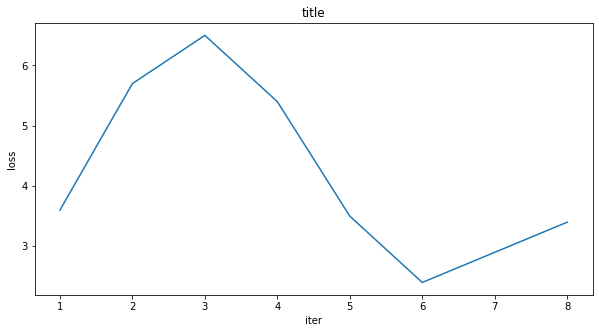

<Figure size 432x288 with 0 Axes>

In [105]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
y = [3.6, 5.7, 6.5, 5.4, 3.5, 2.4, 2.9, 3.4]
x = range(1, len(y)+1)
plt.plot(x, y)  

plt.xlabel("iter")
plt.ylabel("loss")
plt.title("title")

plt.show()
plt.savefig("title"+".jpg")

### Filter metric: the gold facts are ranked at which position in the model's prediction

In [113]:
prediction = torch.randn((2, 10))
print(prediction)
values, indices = torch.topk(prediction, 2, dim=-1)
print(values)
res = torch.zeros((2, 10))
res = res.scatter(1, indices, torch.ones_like(values))
print(res)

tensor([[-0.1171,  0.9228, -1.0146,  0.7802, -0.2508,  1.9984,  0.3217,  0.7905,
         -0.5674, -0.0135],
        [ 1.0949, -0.0833, -2.2209,  1.4983, -0.6510, -0.5991,  0.5539, -0.2395,
         -1.1080, -0.2591]])
tensor([[1.9984, 0.9228],
        [1.4983, 1.0949]])
tensor([[0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])


In [175]:
loss_list = []
metric1_list = []
metric2_list = []
for i in range(10000):
    prediction = torch.randn((25, 10))
    logit_mask = torch.tensor([[0,0,0,0,0,0,0,0,0,0]]*25)
    #print(prediction)
    target = torch.tensor([[0,0,0,0,1,0,0,0,0,0]]*14 + [[0,0,0,0,1,1,0,0,0,0]]*11)
    # calculate cross-entropy loss
    lp = torch.nn.functional.log_softmax(prediction+logit_mask, dim=-1)
    num_flags = torch.sum(target, dim=-1)
    num_flags = torch.max(num_flags, torch.ones_like(num_flags))
    labels = target / num_flags.unsqueeze(-1).repeat(1, prediction.size(-1))
    m = lp * labels
    m = torch.where(torch.isnan(m), torch.zeros_like(m), m)
    loss = torch.sum(- m, dim=-1) * num_flags

    probs = torch.nn.functional.softmax(prediction+logit_mask, dim=-1)
    #print(probs)
    #print(labels)
    m = probs * labels
    m = torch.where(torch.isnan(m), torch.zeros_like(m), m)
    metric1 = torch.sum(m, dim=-1)

    values, indices = torch.topk(probs, 2, dim=-1)
    #print(indices)
    res = torch.zeros_like(prediction)
    res = res.scatter(1, indices, torch.ones_like(values))
    #print(res)
    m = res * labels
    m = torch.where(torch.isnan(m), torch.zeros_like(m), m)
    metric2 = torch.sum(m, dim=-1)
    #print("CEloss = ", loss)
    #print("metric1 = ", metric1)
    #print("metric2 = ", metric2)
    loss_list.append(torch.mean(loss).item())
    metric1_list.append(torch.mean(metric1).item())
    metric2_list.append(torch.mean(metric2).item())
print("loss.mean = ", np.mean(loss_list))
print("metric1.mean = ", np.mean(metric1_list))
print("metric2.mean = ", np.mean(metric2_list))

loss.mean =  3.925786039710045
metric1.mean =  0.100215248785913
metric2.mean =  0.20065199980288745


In [155]:
print(len(dataset_J))
gold_count = {"train":[], "val":[], "ind_test":[], "ood_test":[]}
for j in dataset_J:
    datum = dataset_J[j]
    gold_count[datum['split']].append(len(datum['GoldIds']))
for k in gold_count:
    print(k)
    print(Counter(gold_count[k]))

25474
train
Counter({1: 9987, 2: 7832})
val
Counter({1: 1426, 2: 1115})
ind_test
Counter({1: 1450, 2: 1121})
ood_test
Counter({1: 1477, 2: 1066})


### imgRS & idx2src for Mridu. Check if imgRS include all goldIds 

In [161]:
with open("/home/yingshac/CYS/WebQnA/WebQnA_data/imgRS-Copy1.json", "r") as f:
    tmp = json.load(f)
print(len(tmp))

22265


In [195]:
RS_srcs = []
for j in tmp:
    pprint(tmp[j])
    break
print(len(RS_srcs))

{'RelatedSearches': ['Central Park Path',
                     'Central Park Attractions',
                     'Central Park Zoo',
                     'American Museum of Natural History',
                     'Central Park Entrance',
                     'Central Park Wedding',
                     'Coney Island',
                     'Conservatory Garden',
                     'One World Trade Center',
                     'Central Park East',
                     'Brooklyn Bridge',
                     'Hyde Park',
                     'Statue of Liberty',
                     'Central Park Birds Eye View',
                     'Central Park Plan',
                     'Central Park Night',
                     'Central Park Summer',
                     'Yankee Stadium',
                     'Central Park Playground',
                     'Turtle Pond Central Park',
                     'Central Park Art',
                     'New York City',
                     'Central Park i

In [180]:
RS_srcs = []
for j in tmp:
    RS_srcs.append(tmp[j]['contentUrl'])
print(len(RS_srcs))

22265


In [179]:
gold_srcs = []
for j in img_meta:
    if int(j) < 10000000:
        gold_srcs.append(img_meta[j]['src'])
    #pprint(img_meta[j])
    #break
print(len(gold_srcs))

22265


In [193]:
idx2srcn = {}
for j in img_meta:
    if int(j) < 10000000:
        idx2srcn[int(j)] = img_meta[j]['src']
print(len(idx2srcn))

22265


In [ ]:
with open("/home/yingshac/CYS/WebQnA/WebQnA_data/idx2src-Copy1.pkl", "rb") as f:
    idx2src = pickle.load(f)

In [194]:
print(list(idx2src.keys())[22222:22225])
idx2srcn == idx2src

[22222, 22223, 22224]


True

### QA Decode, beam search

In [196]:
a = torch.randn((16, 512, 768))
print(a[:, -1:, :].size())

torch.Size([16, 1, 768])


In [202]:
a = torch.randn((16, 1, 35, 768))
print(a.repeat([1, 5, 1, 1]).size())

torch.Size([16, 5, 35, 768])


In [208]:
a = torch.randn((16, 3))
#print(a)
#print(torch.div(a, 3))
print(a[:1, ...].size())

torch.Size([1, 3])


In [214]:
for i, j in enumerate(['t','y', 'u', 'g', 'f']):
    print(i, j)

0 t
1 y
2 u
3 g
4 f


In [232]:
from random import random as rand
print(rand())

0.6448330181381462


In [279]:
random.seed(42)
r=[]
for i in range(38):
    if rand()<0.8:
        r.append(1)
    elif rand()<0.5:
        r.append(-1)
    else:
        r.append(0)
print(np.mean(r))

0.6578947368421053


In [274]:
random.seed(42)
r = []
for i in range(38):
    a = rand()
    if a<0.8:
        r.append(1)
    elif a<0.9:
        r.append(8)
    else:
        r.append(0)
print(np.mean(r))

2.0526315789473686


In [281]:
x = torch.randn((2, 7))
print(x[:, :1]*0 + 0)

tensor([[0.],
        [0.]])


In [283]:
Q = [1,2,3]
b = Q.copy()
b += [0,0,0]
print(Q)

[1, 2, 3]


In [350]:
ans = []
qs = []
for j in dataset_J:
    if len(qs) == 1669: break
    if dataset_J[j]['split'] in "val":
        qs.append(dataset_J[j]['Q'])
        ans.append(dataset_J[j]['A'])
pprint(qs[-1])

#pprint(ans)

('"Are both of the men\'s headwear in the Punjabi wedding ritual and the '
 'traditional wedding ceremony of the yoruba ethnic group in Nigeria striped?"')


In [352]:
tokens_b = tokenizer.tokenize(qs[-1])
print(len(tokens_b))

31


### Language Eval

In [103]:
import sys
sys.path.append("/CYS/WebQnA/VLP/coco-caption")
from pycocoevalcap.spice.spice import Spice
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.cider.cider import Cider

In [531]:
class Evaluate(object):
    def __init__(self):
        self.scorers = [
            (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
            (Meteor(), "METEOR"),
            (Rouge(), "ROUGE_L"),
            #(Cider(), "CIDEr"),
            #(Spice(), "Spice")
        ]
    
    def score(self, ref, hypo):
        final_scores = {}
        for scorer, method in self.scorers:
            score, scores = scorer.compute_score(ref, hypo)
            if type(score) == list:
                for m, s in zip(method, score):
                    final_scores[m] = s
            else:
                final_scores[method] = score
        return final_scores

    def evaluate(self, return_scores=False, **kwargs):
        ans = kwargs.pop('ref', {})
        cand = kwargs.pop('cand', {})

        hypo = {}
        ref = {}
        i = 0
        for i in range(len(cand)):
            hypo[i] = cand[i]
            ref[i] = [ans[i]]
        
        final_scores = self.score(ref, hypo)
        print ('Bleu_1:\t', final_scores['Bleu_1'])
        print ('Bleu_2:\t', final_scores['Bleu_2'])
        print ('Bleu_3:\t', final_scores['Bleu_3'])
        print ('Bleu_4:\t', final_scores['Bleu_4'])
        print ('METEOR:\t', final_scores['METEOR'])
        print ('ROUGE_L:', final_scores['ROUGE_L'])
        #print ('CIDEr:\t', final_scores['CIDEr'])
        #print ('Spice:\t', final_scores['Spice'])

        if return_scores:
            return final_scores
        

In [532]:
eval_f = Evaluate()


In [171]:
cands = [['basketball rolling in a grassland'], ["perererer"]]
refs = ['basketball and football land', "window snow clock on the table raining cats and dogs"]
eval_f.evaluate(cand=cands, ref=refs)

{'testlen': 6, 'reflen': 14, 'guess': [6, 4, 3, 2], 'correct': [1, 0, 0, 0]}
ratio: 0.42857142854081637
Bleu_1:	 0.0439328563379769
Bleu_2:	 1.7015122094121777e-09
Bleu_3:	 6.3362143170544154e-12
Bleu_4:	 4.279076665811349e-13
METEOR:	 0.03870967741935485
ROUGE_L: 0.11338289962825278


### VQA Eval (EM, F1)

In [45]:
import spacy

In [46]:
import numpy as np
nlp = spacy.load("en_core_web_sm", disable=["ner","textcat","parser"])

In [35]:
x = nlp("hi hello jobs are you I'm fine. I did see you")
print(" ".join([token.lemma_ for token in x]))

hi hello job be you I be fine . I do see you


In [47]:
def normalize_text(s):
    import string, re
    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text): # additional: converting numbers to digit form
        return " ".join([str(toNum(w)) for w in text.split()])
        #return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation) - set(['.'])
        text1 = "".join(ch for ch in text if ch not in exclude)
        return re.sub(r"\.(?!\d)", "", text1)

    def lower(text):
        return text.lower()
    
    def lemmatization(text):
        return " ".join([token.lemma_ for token in nlp(text)])
    
    if len(s.strip()) < 4: # FIXME: Is there a more general solution for handling answers like "+", "The"
        return white_space_fix(lemmatization(lower(s)))
    return white_space_fix(lemmatization(remove_articles(remove_punc(lower(s)))))

In [51]:
from collections import Counter
cands = ["hi 2", "good job deserves bonus 2 percent"]
a = 'two and good jobs'
def compute_vqa_metrics(cands, a):
    if len(cands) == 0: return (0,0,0)
    bow_a = normalize_text(a).split()
    #bow_a = [str(toNum(w)) for w in bow_a]
    F1 = []
    EM = 0
    RE = []
    PR = []
    for c in cands:
        bow_c = normalize_text(c).split()
        #bow_c = [str(toNum(w)) for w in bow_c]
        if bow_c == bow_a:
            EM = 1
        #print(bow_a, bow_c)
        
        #overlap = float(len([w for w in bow_c if w in bow_a]))
        #precision = overlap/(len(bow_c) + 1e-5)
        #recall = overlap / (len(bow_a) + 1e-5)
        common = Counter(bow_a) & Counter(bow_c)
        num_same = sum(common.values())
        if num_same == 0:
            return (0,0,0,0,0)
        precision = 1.0 * num_same / len(bow_c)
        recall = 1.0 * num_same / len(bow_a)
        
        RE.append(recall)
        PR.append(precision)
        f1 = 2*precision*recall / (precision + recall)
        F1.append(f1)
    PR_avg = np.mean(PR)
    RE_avg = np.mean(RE)
    F1_avg = np.mean(F1)
    F1_max = np.max(F1)
    return (F1_avg, F1_max, EM, RE_avg, PR_avg)
print(compute_vqa_metrics(cands, a))

(0.4666666666666667, 0.6, 0, 0.5, 0.5)


In [49]:
from word2number import w2n
def toNum(word):
    try: return w2n.word_to_num(word)
    except:
        return word

In [50]:
def compute_bertscore(cands, a):
    metric.add_batch(predictions = cands, references = [a]*len(cands))
    score = metric.compute(lang='en')
    return np.mean(score['f1']), np.max(score['f1'])

In [612]:
from pprint import pprint
import re
with open("/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/qa_alone_txt_0528data/qa_infr/ind_test|ood_test_qainfr_-1_beam5_txt_True_txt_dataset_J.txt", "r") as f:
    lines = f.readlines()
while True:
    if lines[0].strip() == "-----Starting writing results:-----":
        lines.pop(0)
        lines.pop(0)
        break
    else:
        lines.pop(0)

pt = 'Q'
folder = {'Q':[], 'A':[], 'C':[], 'TopC':[]}
for l in lines:
    if pt == 'Q':
        folder[pt].append(l.strip())
        pt = 'A'
    elif pt == 'A':
        folder[pt].append(l.strip())
        pt = 'OC'
    elif pt == 'OC': # Output Confidence
        pt = 'C'
        folder[pt].append([])   
    elif pt == 'C':
        folder[pt][-1].append(l.strip())
        if len(folder[pt][-1]) == beam:
            folder['TopC'].append([folder[pt][-1][0]])
            pt = ''
    else:
        pt='Q' # skip empty line between samples
    #if len(folder['Q']) > 10: break
assert len(folder['Q']) == len(folder['A']) == len(folder['C'])
print(len(folder['Q']))

1594


In [601]:
F1_avg_scores = []
F1_max_scores = []
EM_scores = []
pr_scores = []
re_scores = []
F1_avg_bertscores = []
F1_max_bertscores = []
for cands, a in zip(folder['C'], folder['A']):
    assert len(cands)==beam
    #cands=["yes", "no"]
    #cands = [cands[0]]
    F1_avg, F1_max, EM, pr, re = compute_vqa_metrics([cands[0]], a)
    F1_avg_scores.append(F1_avg)
    F1_max_scores.append(F1_max)
    EM_scores.append(EM)
    
    pr_scores.append(pr)
    re_scores.append(re)
    
    F1_avg_bertscore, F1_max_bertscore = compute_bertscore([cands[0]], a)
    F1_avg_bertscores.append(F1_avg_bertscore)
    F1_max_bertscores.append(F1_max_bertscore)
print("F1_avg = ", np.mean(F1_avg_scores))
print("F1_max = ", np.mean(F1_max_scores))
print("EM = ", np.mean(EM_scores))
print(np.mean(pr_scores))
print(np.mean(re_scores))
print("F1_avg_bertscore = ", np.mean(F1_avg_bertscores))
print("F1_max_bertscore = ", np.mean(F1_max_bertscores))

F1_avg =  0.40114114637536724
F1_max =  0.40114114637536724
EM =  0.3096085409252669
0.44564661839357683
0.41190741159487476
F1_avg_bertscore =  0.9198625898728874
F1_max_bertscore =  0.9198625898728874


In [640]:
F1_avg_scores = []
F1_max_scores = []
EM_scores = []
pr_scores = []
re_scores = []
F1_avg_bertscores = []
F1_max_bertscores = []
for cands, a in zip(folder['TopC'], folder['A']):
    assert len(cands)==1
    #cands=["yes", "no"]
    #cands = [cands[0]]
    F1_avg, F1_max, EM, pr, re = compute_vqa_metrics(cands, a)
    F1_avg_scores.append(F1_avg)
    F1_max_scores.append(F1_max)
    EM_scores.append(EM)
    
    pr_scores.append(pr)
    re_scores.append(re)
    
    F1_avg_bertscore, F1_max_bertscore = compute_bertscore(cands, a)
    F1_avg_bertscores.append(F1_avg_bertscore)
    F1_max_bertscores.append(F1_max_bertscore)
print("F1_avg = ", np.mean(F1_avg_scores))
print("F1_max = ", np.mean(F1_max_scores))
print("EM = ", np.mean(EM_scores))
print(np.mean(pr_scores))
print(np.mean(re_scores))
print("F1_avg_bertscore = ", np.mean(F1_avg_bertscores))
print("F1_max_bertscore = ", np.mean(F1_max_bertscores))

F1_avg =  0.1945779707775112
F1_max =  0.1945779707775112
EM =  0.06838143036386449
0.3084492635880539
0.23714602027393658
F1_avg_bertscore =  0.8278166579930964
F1_max_bertscore =  0.8278166579930964


In [605]:
scores = eval_f.evaluate(cand=folder['TopC'], ref=folder['A'], return_scores=True)
print(scores)

{'testlen': 6448, 'reflen': 10022, 'guess': [6448, 3107, 2151, 1613], 'correct': [2270, 444, 123, 32]}
ratio: 0.643384553981177


KeyboardInterrupt: 

In [1135]:
human_img_json = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/human_txt.json", "r"))
C = [[str(datum['CuratedEvalAnswer'])] for datum in human_img_json]
A = [str(datum['Answer']).replace('"', "") for datum in human_img_json]
F1_avg_scores = []
F1_max_scores = []
EM_scores = []
pr_scores = []
re_scores = []
F1_avg_bertscores = []
F1_max_bertscores = []
hard = []
for cands, a in zip(C, A):
    assert len(cands)==1
    #cands=["yes", "no"]
    #cands = [cands[0]]
    F1_avg, F1_max, EM, re, pr = compute_vqa_metrics(cands, a)
    F1_avg_scores.append(F1_avg)
    F1_max_scores.append(F1_max)
    EM_scores.append(EM)
    
    pr_scores.append(pr)
    re_scores.append(re)
    
    if re < 0.2:
        hard.append((pr, re, cands[0], a))
    
    F1_avg_bertscore, F1_max_bertscore = compute_bertscore(cands, a)
    F1_avg_bertscores.append(F1_avg_bertscore)
    F1_max_bertscores.append(F1_max_bertscore)
print("F1_avg = ", np.mean(F1_avg_scores))
print("F1_max = ", np.mean(F1_max_scores))
print("EM = ", np.mean(EM_scores))
print("precision = ", np.mean(pr_scores))
print("recall = ", np.mean(re_scores))
print("F1_avg_bertscore = ", np.mean(F1_avg_bertscores))
print("F1_max_bertscore = ", np.mean(F1_max_bertscores))

F1_avg =  0.42059361892096464
F1_max =  0.42059361892096464
EM =  0.0671462829736211
precision =  0.431952750235792
recall =  0.642326684758306
F1_avg_bertscore =  0.8901060332211373
F1_max_bertscore =  0.8901060332211373


In [1119]:
hard[:10]

[(0,
  0,
  'There were more people killed in the Erwadi fire incident.',
  'the blaze at Mecca Intermediate School No. 31'),
 (0.14285714285714285,
  0.13333333333333333,
  'The Thracians and Illyrians caused problems for Aeropus, while the Romans caused problems for Philip V.',
  'The Roman Empire, Thracians, and IIIyrians were the groups who opposed and threatened Macadonia during their rule.'),
 (0.3333333333333333,
  0.1875,
  'Yes, Cyrus the Great died before the Greco-Persian Wars even began.',
  "No, the Greco-Persian Wars ended in 449 BC which is after Cyrus the Great's death in 530 BC."),
 (0.5,
  0.15384615384615385,
  'No, the latter is a muscle.',
  'No, while the AICA is an artery, the AIIS provides attachment for the inguinal ligament around the pelvis.'),
 (0, 0, 'They are both types of firearm.', 'Guns'),
 (0,
  0,
  'Bits is the type of data physically transferred in a data signaling rate and is what data-transfer measures the average number of.',
  'The bitrate.'),
 

/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


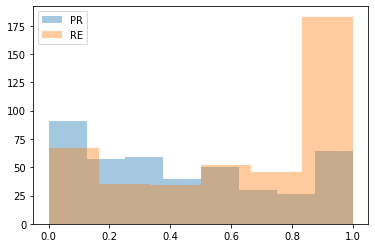

In [1136]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(pr_scores, kde=False, label="PR")
sns.distplot(re_scores, kde=False, label="RE")
plt.legend()

In [1106]:
human_img_json = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/human_txt.json", "r"))
C = [str(datum['CuratedEvalAnswer']) for datum in human_img_json]
A = [[str(datum['Answer']).replace('"', "")] for datum in human_img_json]
F1_avg_scores = []
F1_max_scores = []
EM_scores = []
pr_scores = []
re_scores = []
F1_avg_bertscores = []
F1_max_bertscores = []
for cands, a in zip(A, C):
    assert len(cands)==1
    #cands=["yes", "no"]
    #cands = [cands[0]]
    F1_avg, F1_max, EM, re, pr = compute_vqa_metrics(cands, a)
    F1_avg_scores.append(F1_avg)
    F1_max_scores.append(F1_max)
    EM_scores.append(EM)
    
    pr_scores.append(pr)
    re_scores.append(re)
    
    F1_avg_bertscore, F1_max_bertscore = compute_bertscore(cands, a)
    F1_avg_bertscores.append(F1_avg_bertscore)
    F1_max_bertscores.append(F1_max_bertscore)
print("F1_avg = ", np.mean(F1_avg_scores))
print("F1_max = ", np.mean(F1_max_scores))
print("EM = ", np.mean(EM_scores))
print("precision = ", np.mean(pr_scores))
print("recall = ", np.mean(re_scores))
print("F1_avg_bertscore = ", np.mean(F1_avg_bertscores))
print("F1_max_bertscore = ", np.mean(F1_max_bertscores))

F1_avg =  0.3968670058058623
F1_max =  0.3968670058058623
EM =  0.05275779376498801
precision =  0.589568890993318
recall =  0.4119094385384606
F1_avg_bertscore =  0.8901060323635165
F1_max_bertscore =  0.8901060323635165


In [ ]:
scores = eval_f.evaluate(cand=C, ref=A, return_scores=True)
print(scores)

In [1137]:
human_img_json = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/human_img.json", "r"))
C = [[str(datum['CuratedEvalAnswer'])] for datum in human_img_json]
A = [str(datum['A']).replace('"', "") for datum in human_img_json]
F1_avg_scores = []
F1_max_scores = []
EM_scores = []
pr_scores = []
re_scores = []
F1_avg_bertscores = []
F1_max_bertscores = []
hard = []
for cands, a in zip(C, A):
    assert len(cands)==1
    #cands=["yes", "no"]
    #cands = [cands[0]]
    F1_avg, F1_max, EM, re, pr = compute_vqa_metrics(cands, a)
    F1_avg_scores.append(F1_avg)
    F1_max_scores.append(F1_max)
    EM_scores.append(EM)
    
    pr_scores.append(pr)
    re_scores.append(re)
    
    if re < 0.2:
        hard.append((pr, re, cands[0], a))
    
    F1_avg_bertscore, F1_max_bertscore = compute_bertscore(cands, a)
    F1_avg_bertscores.append(F1_avg_bertscore)
    F1_max_bertscores.append(F1_max_bertscore)
print("F1_avg = ", np.mean(F1_avg_scores))
print("F1_max = ", np.mean(F1_max_scores))
print("EM = ", np.mean(EM_scores))
print("precision = ", np.mean(pr_scores))
print("recall = ", np.mean(re_scores))
print("F1_avg_bertscore = ", np.mean(F1_avg_bertscores))
print("F1_max_bertscore = ", np.mean(F1_max_bertscores))

F1_avg =  0.28911882166260805
F1_max =  0.28911882166260805
EM =  0.05895691609977324
precision =  0.21302313477193213
recall =  0.7726460425440016
F1_avg_bertscore =  0.860675878265277
F1_max_bertscore =  0.860675878265277


/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


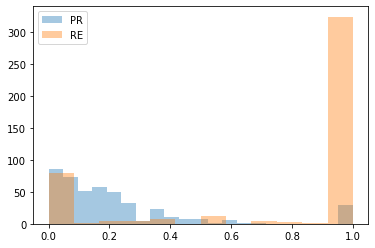

In [1138]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(pr_scores, kde=False, label="PR")
sns.distplot(re_scores, kde=False, label="RE")
plt.legend()

In [1139]:
hard[:10]

[(0, 0, 'Both have holes in the middle.', 'A hole'),
 (0, 0, 'You would see a greenish blue dome.', 'green'),
 (0,
  0,
  'Yes, you can find black and yellow on both the wings and the tail, although there is only white on the wings.',
  'No'),
 (0,
  0,
  'Neither depict a white horse, only lighter and darker shades of brown.',
  'both'),
 (0, 0, 'An open doorway.', 'double door'),
 (0.25,
  0.16666666666666666,
  'Both have an entrance, multiple floors, windows, and a roof.',
  'They are both historic buildings with rows of windows on their facade.'),
 (0, 0, 'Yes, she is.', 'no'),
 (0, 0, 'The roof curves up to a flat top.', 'dome, circular'),
 (0, 0, 'Grain is shown between the two sets of bare legs.', 'Wheat'),
 (0, 0, 'Cycle rickshaws, bicycles and cars.', 'Scooter, car, rickshaw')]

In [38]:
human_img_json = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/human_img.json", "r"))
human_img_json2 = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/human_img2.json", "r"))
print(len(human_img_json))
print(len(human_img_json2))
C_all = list(zip([[str(datum['CuratedEvalAnswer'])] for datum in human_img_json], [[str(datum['CuratedEvalAnswer'])] for datum in human_img_json2]))
C = [[str(datum['CuratedEvalAnswer'])] for datum in human_img_json]
print(len(C_all), len(C))
A = [str(datum['A']).replace('"', "") for datum in human_img_json]
Q = [str(datum['Q']).replace('"', "") for datum in human_img_json]
F1_avg_scores = []
F1_max_scores = []
EM_scores = []
pr_scores = []
re_scores = []
F1_avg_bertscores = []
F1_max_bertscores = []
for cands, a in zip(C, A):
    assert len(cands)==1
    #cands=["yes", "no"]
    #cands = [cands[0]]
    F1_avg, F1_max, EM, re, pr = compute_vqa_metrics(cands, a)
    F1_avg_scores.append(F1_avg)
    F1_max_scores.append(F1_max)
    EM_scores.append(EM)
    #print(re)
    pr_scores.append(pr)
    re_scores.append(re)
    
    #F1_avg_bertscore, F1_max_bertscore = compute_bertscore(cands, a)
    #F1_avg_bertscores.append(F1_avg_bertscore)
    #F1_max_bertscores.append(F1_max_bertscore)
print("F1_avg = ", np.mean(F1_avg_scores))
print("F1_max = ", np.mean(F1_max_scores))
print("EM = ", np.mean(EM_scores))
print(np.mean(pr_scores))
print(np.mean(re_scores))
#print("F1_avg_bertscore = ", np.mean(F1_avg_bertscores))
#print("F1_max_bertscore = ", np.mean(F1_max_bertscores))

440
1384
440 440
F1_avg =  0.2931031121032146
F1_max =  0.2931031121032146
EM =  0.05909090909090909
0.21572370451056735
0.7844805194805194


In [39]:
t = []
for x in C_all:
    if not x[0][0] == x[1][0]:
        t.append(x)
print(len(t))
print(t)

0
[]


In [1082]:
answer_mod = 'img'
with open("/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/Human/multi_candidates_{}.txt".format(answer_mod), "w") as f:
    for c, a, q in zip(C, A, Q):
        f.write('\n'.join(['Q: '+q, 'GTH A: '+a, 'New A: '+c[0]]))
        f.write('\n\n')

In [1066]:
scores = eval_f.evaluate(cand=C, ref=A, return_scores=True)
print(scores)

{'testlen': 4551, 'reflen': 3200, 'guess': [4551, 4134, 3750, 3371], 'correct': [1329, 724, 422, 252]}
ratio: 1.4221874999995556


KeyboardInterrupt: 

In [141]:
import torch
x = torch.tensor([1.,2.,3.])
x.numpy()

array([1., 2., 3.], dtype=float32)

In [134]:
a = np.array([1.,0.,0.])
[a, 1-a]

[array([1., 0., 0.]), array([0., 1., 1.])]

In [148]:
x = torch.randn((16, 4))
print(x)
x.view(-1, 4, 1).repeat(1,1,2)

tensor([[ 0.3156,  0.7674, -0.3291, -0.4810],
        [-0.0629, -0.0141, -0.7759, -0.2236],
        [ 0.0744,  1.0859,  0.4158,  0.0652],
        [ 0.2808, -1.6304,  0.4321, -0.4667],
        [ 1.0484, -0.4754, -1.2340,  0.6366],
        [ 1.9394,  0.4418,  1.3128,  0.3053],
        [ 0.3235, -1.0742, -0.8933,  1.9124],
        [-1.8909,  0.7299,  1.8122,  0.4205],
        [-0.5046, -2.1711, -1.8566, -1.9120],
        [ 0.6349,  0.3143, -1.5268,  0.3490],
        [ 1.0041,  1.0608,  0.6586,  0.3184],
        [-0.3892,  0.0465,  0.4201,  0.3185],
        [-0.1947,  0.4879,  0.4646, -0.2938],
        [-0.9678,  0.0102, -0.4266,  1.7140],
        [-0.7898, -1.3566,  1.3410, -0.5791],
        [-2.0403, -1.0329, -1.1500,  0.1773]])


tensor([[[ 0.3156,  0.3156],
         [ 0.7674,  0.7674],
         [-0.3291, -0.3291],
         [-0.4810, -0.4810]],

        [[-0.0629, -0.0629],
         [-0.0141, -0.0141],
         [-0.7759, -0.7759],
         [-0.2236, -0.2236]],

        [[ 0.0744,  0.0744],
         [ 1.0859,  1.0859],
         [ 0.4158,  0.4158],
         [ 0.0652,  0.0652]],

        [[ 0.2808,  0.2808],
         [-1.6304, -1.6304],
         [ 0.4321,  0.4321],
         [-0.4667, -0.4667]],

        [[ 1.0484,  1.0484],
         [-0.4754, -0.4754],
         [-1.2340, -1.2340],
         [ 0.6366,  0.6366]],

        [[ 1.9394,  1.9394],
         [ 0.4418,  0.4418],
         [ 1.3128,  1.3128],
         [ 0.3053,  0.3053]],

        [[ 0.3235,  0.3235],
         [-1.0742, -1.0742],
         [-0.8933, -0.8933],
         [ 1.9124,  1.9124]],

        [[-1.8909, -1.8909],
         [ 0.7299,  0.7299],
         [ 1.8122,  1.8122],
         [ 0.4205,  0.4205]],

        [[-0.5046, -0.5046],
         [-2.1711, -2.1711]

In [153]:
y = torch.randn((16, 2, 10))
print(y.transpose(2, 1).size())

torch.Size([16, 10, 2])


In [431]:
pr_list = []
re_list = []
f1_list = []
th_list = [0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98]
for th in th_list:
    print("\nth = ", th)
    for i in range(10000):
        x = torch.rand((500, 20, 1)).transpose(2,1)
        #x = torch.nn.functional.softmax(x, dim=-1).transpose(2,1)
        #print(x)
        x = (x>th).long()[:, 0, :]
        y = torch.tensor([[0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0]]*500)
        overlap = torch.sum(x * y, dim=-1) # batch_size
        #if torch.sum(x, dim=-1)[0] == 0:
            #assert overlap[0] == 0
            #continue
        #print(y)
        #print(x)
        pr = overlap / (torch.sum(x, dim=-1) + 1e-8) # batch_size
        re = overlap / (torch.sum(y, dim=-1) + 1e-8) # batch_size
        #print(pr)
        #print(re)
        
        f1 = 2*pr*re / (pr+re+1e-5)
        #print(pr, re, f1)
        pr_list.append(torch.mean(pr).item())
        re_list.append(torch.mean(re).item())
        f1_list.append(torch.mean(f1).item())
    #print(len(pr_list))
    print(np.mean(pr_list), np.mean(re_list), np.mean(f1_list))
    pr_list = []
    re_list = []
    f1_list = []


th =  0.84
0.581591745018959 0.1599294506341219 0.24164733769893645

th =  0.86
0.5708191047787666 0.13996390127837657 0.2164848294481635

th =  0.88
0.5534925982177258 0.1199979681789875 0.19004859023690224

th =  0.9
0.5268986646205187 0.0999467679746449 0.1621923999488354

th =  0.92
0.4867339243143797 0.08001623375415802 0.13309250197559594

th =  0.94
0.426108054548502 0.06001446578390896 0.10238548788577319

th =  0.96
0.3351817409932613 0.04003498272523284 0.0700848739091307

th =  0.98
0.1995857253074646 0.020020283722225578 0.03597855957876891


In [423]:
base = 0.6
for th in th_list:
    print("{}: {}".format(th, base * (1-th**20)))

0.84: 0.5816457361056899
0.86: 0.5706153667089988
0.88: 0.5534623238170862
0.9: 0.5270540072456584
0.92: 0.48678400250232196
0.94: 0.4259362553211231
0.96: 0.33479853967235557
0.98: 0.19943521694694347


In [425]:
for th in th_list:
    print(th, th**20)

0.84 0.030590439823849968
0.86 0.04897438881833526
0.88 0.07756279363818959
0.9 0.12157665459056935
0.92 0.1886933291627967
0.94 0.2901062411314615
0.96 0.4420024338794074
0.98 0.6676079717550942


### Bertscore

In [519]:
from datasets import load_metric
metric = load_metric("bertscore")

In [534]:
cands = ["rectangle"]
a = "square"

print(compute_bertscore(cands, a))

(0.9992030262947083, 0.9992030262947083)


/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:1321: FutureWarning:

The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.



In [297]:
cands = ["circle", "round shape", "rectangular"]
a = "H-shape"

print(compute_bertscore(cands, a))

(0.878792405128479, 0.930027425289154)


In [296]:
cands = ["China", "India", "The United Kindom"]
a = "United States"

print(compute_bertscore(cands, a))

(0.837743878364563, 0.8547501564025879)


In [93]:
X = get_bert_embedding("rounded")
Y = get_bert_embedding("round")
np.array(np.dot(X, Y) / (np.linalg.norm(X)*np.linalg.norm(Y)))

array(0.92775163)

In [62]:
def lemmatization(text):
    return " ".join([token.lemma_ for token in nlp(text)])


'circular'

In [143]:
lemmatization("circular")

'circular'

In [75]:
from nltk.corpus import wordnet as wn

# Just to make it a bit more readable
WN_NOUN = 'n'
WN_VERB = 'v'
WN_ADJECTIVE = 'a'
WN_ADJECTIVE_SATELLITE = 's'
WN_ADVERB = 'r'

def convert(word, from_pos, to_pos):    
    """ Transform words given from/to POS tags """

    synsets = wn.synsets(word, pos=from_pos)

    # Word not found
    if not synsets:
        return []

    # Get all lemmas of the word (consider 'a'and 's' equivalent)
    lemmas = []
    for s in synsets:
        for l in s.lemmas():
            if s.name().split('.')[1] == from_pos or from_pos in (WN_ADJECTIVE, WN_ADJECTIVE_SATELLITE) and s.name().split('.')[1] in (WN_ADJECTIVE, WN_ADJECTIVE_SATELLITE):
                lemmas += [l]

    # Get related forms
    derivationally_related_forms = [(l, l.derivationally_related_forms()) for l in lemmas]

    # filter only the desired pos (consider 'a' and 's' equivalent)
    related_noun_lemmas = []

    for drf in derivationally_related_forms:
        for l in drf[1]:
            if l.synset().name().split('.')[1] == to_pos or to_pos in (WN_ADJECTIVE, WN_ADJECTIVE_SATELLITE) and l.synset().name().split('.')[1] in (WN_ADJECTIVE, WN_ADJECTIVE_SATELLITE):
                related_noun_lemmas += [l]

    # Extract the words from the lemmas
    words = [l.name() for l in related_noun_lemmas]
    len_words = len(words)

    # Build the result in the form of a list containing tuples (word, probability)
    result = [(w, float(words.count(w)) / len_words) for w in set(words)]
    result.sort(key=lambda w:-w[1])

    # return all the possibilities sorted by probability
    return result

In [117]:
nounify("octagonal")

'octagonal'

In [109]:
def nounify(word):
    L = convert(word, WN_ADJECTIVE, WN_NOUN)
    if L:
        return L[0][0]
    else:
        return word

In [141]:
from sklearn.cluster import AgglomerativeClustering, KMeans
shapes = [s[0].replace("shape", "") for s in a.most_common(20)]
print(shapes)
X = np.array([get_bert_embedding(nounify(s)) for s in shapes])
clustering = KMeans(n_clusters=6).fit(X)

shape2cluster = dict(zip(shapes, clustering.labels_))
cluster2shape = defaultdict(lambda: [])
for s in shape2cluster:
    c = shape2cluster[s]
    cluster2shape[c].append(s)
pprint(cluster2shape)

['circle', 'round', 'triangle', 'square', 'arch', 'rectangle', 'star', 'circular', 'rectangular', 'curve', 'oval', 'dome', 'diamond', 'semicircle', 'octagon', 'pyramid', 'sphere', 'rounded', 'cylindrical', 'triangular']
defaultdict(<function <lambda> at 0x7f86bacf9f80>,
            {0: ['triangle',
                 'star',
                 'curve',
                 'dome',
                 'diamond',
                 'octagon',
                 'pyramid',
                 'sphere',
                 'cylindrical',
                 'triangular'],
             1: ['round', 'square', 'rounded'],
             2: ['circle', 'circular'],
             3: ['rectangle', 'rectangular', 'semicircle'],
             4: ['oval'],
             5: ['arch']})


In [4]:
def get_bert_embedding(text):
    marked_text = "[CLS] " + text + " [SEP]"

    # Tokenize our sentence with the BERT tokenizer.
    tokenized_text = tokenizer.tokenize(marked_text)
    tokenized_text = [w for w in tokenized_text if not w in stopwords.words()]
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text)
    
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
            # becase we set `output_hidden_states = True`, the third item will be the hidden states from all layers. 
        hidden_states = outputs[2]
    token_embeddings = torch.stack(hidden_states, dim=0)
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    token_embeddings = token_embeddings.permute(1,0,2)
    # output[0] = last_hidden_state, of shape (batch_size, sequence_length, hidden_size)
    # output[1] = pooler_output, of shape (batch_size, hidden_size), last hidden state of the first token of the sequence (CLS token)
    token_vecs_sum = []
    for token in token_embeddings:
        # Sum the vectors from the last four layers.
        sum_vec = torch.sum(token[-4:], dim=0)
        token_vecs_sum.append(sum_vec)
    token_vecs_sum = torch.stack(token_vecs_sum)
    result = torch.mean(token_vecs_sum[:], dim=0)
    return result.tolist()

In [282]:
print(score)
print(np.mean(score['precision']), np.mean(score['recall']), np.max(score['f1']))

{'precision': [0.9926685690879822, 0.994318425655365, 0.7717434167861938], 'recall': [0.9926685690879822, 0.994318425655365, 0.855967104434967], 'f1': [0.9926685690879822, 0.994318425655365, 0.8116762042045593], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.8(hug_trans=4.5.1)'}
0.9195768038431803 0.9476513663927714 0.994318425655365


In [502]:
tmp = json.load(open("/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/tmp_jsons/Json_20210526.json", "r"))
pprint(tmp[0])

{'Answer': 'They were both polytheistic and have several deities to believe '
           'in.',
 'BucketId': -321887566,
 'DistractorFacts': [{'fact': 'According to another theory proposed in the '
                              '19th century, the first people to adopt '
                              'cultural characteristics regarded as Celtic '
                              'were the people of the Iron Age Hallstatt '
                              'culture in central Europe (c. 800–450 BC), '
                              'named for the rich grave finds in Hallstatt, '
                              'Austria.',
                      'showed_to_judges': True,
                      'title': 'Celts - Wikipedia',
                      'url': 'https://en.wikipedia.org/wiki/Celts'},
                     {'fact': 'Additionally, the Celtic Druids gave us a '
                              'tradition that is still with us to this very '
                              'day. Druids considered the o

In [548]:
with open("/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/tmp_jsons/all_0528.json", "r") as f:
    tmp = json.load(f)
print(len(tmp))

7921


In [550]:
new_txt_json = {}
i = 0
print(type(tmp))
for j in tmp:
    datum = j
    new_txt_json[str(i)] = datum.copy()
    new_txt_json[str(i)]['Q'] = datum['Question']
    new_txt_json[str(i)]['A'] = datum['Answer']
    new_txt_json[str(i)].pop('Question')
    new_txt_json[str(i)].pop('Answer')
    new_txt_json[str(i)].pop('Split')
    i+=1
print(len(new_txt_json))
#json.dump(new_txt_json, open("/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/tmp_jsons/txt_dataset_J.json", "w"), indent=4)

<class 'list'>
7921


In [551]:
txt_tr = 0
txt_val = 0
txt_ind = 0
txt_ood = 0
for i in new_txt_json:
    if new_txt_json[i]['split'] == 'train': txt_tr += 1
    elif new_txt_json[i]['split'] == 'val': txt_val += 1
    elif new_txt_json[i]['split'] == 'ind_test': txt_ind += 1
    elif new_txt_json[i]['split'] == 'ood_test': txt_ood += 1
print(txt_tr, txt_val, txt_ind, txt_ood)

5534 793 801 793


In [590]:
print(Counter([len(new_txt_json[i]['A'].strip().split()) for i in new_txt_json]))

Counter({1: 1652, 2: 1029, 3: 688, 4: 453, 5: 403, 6: 366, 7: 336, 9: 297, 8: 279, 11: 228, 10: 226, 13: 225, 12: 211, 15: 183, 14: 183, 18: 145, 16: 141, 17: 130, 20: 127, 19: 124, 21: 100, 22: 73, 23: 56, 24: 51, 25: 33, 28: 28, 26: 26, 27: 25, 30: 20, 29: 14, 32: 12, 34: 7, 31: 7, 35: 6, 36: 5, 33: 5, 39: 4, 37: 4, 44: 4, 41: 2, 38: 2, 45: 2, 42: 1, 56: 1, 55: 1, 49: 1, 43: 1, 54: 1, 48: 1, 68: 1, 47: 1})


### Filter Eval Curve

In [667]:
f = open("/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/tmp-filter_alone_w_img/filter_curve.txt", "r")
lines = f.readlines()
f.close()
i = 0
th_list = []
pr_list = []
re_list = []
f1_list = []
for l in lines:
    if i%5 == 0:
        th_list.append(float(l.strip().split()[-1]))
    elif i%5 == 1:
        pr_list.append(float(l.strip().split()[-1]))
    elif i%5 == 2:
        re_list.append(float(l.strip().split()[-1]))
    elif i%5 == 3:
        f1_list.append(float(l.strip().split()[-1]))
    i += 1
assert len(th_list) == len(pr_list) == len(re_list) == len(f1_list)

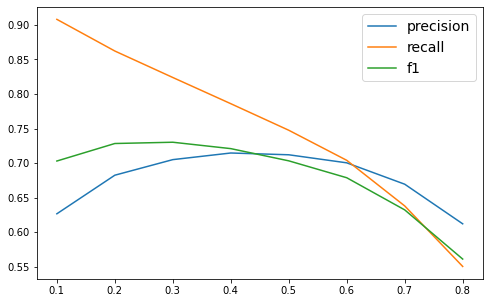

In [670]:
plt.figure(figsize=(8, 5))
plt.plot(th_list, pr_list, label="precision")
plt.plot(th_list, re_list, label="recall")
plt.plot(th_list, f1_list, label="f1")
plt.legend(loc="upper right", fontsize=14)
plt.show()

### Shuffle distractors and fix

In [442]:
'''
print(len(dataset_J))
dataset_J_fix_dis = {}
for j in dataset_J:
    dataset_J_fix_dis[j] = dataset_J[j]
    random.shuffle(dataset_J_fix_dis[j]['DistractorIds'])
print(len(dataset_J_fix_dis))
json.dump(dataset_J_fix_dis, open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/dataset_J0526.json", "w"), indent=4)
'''

25474
25474


In [99]:
dataset_J_fix_dis = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/img_dataset_J_0623.json", "r"))
new_txt_json = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/txt_dataset_J.json", "r"))

In [100]:
print([k for k in range(25474) if str(k) not in dataset_J_fix_dis])

[233, 338, 443, 1233, 1234, 2141, 2361]


In [101]:
print(Counter([len(dataset_J_fix_dis[j]['GoldIds']) for j in dataset_J_fix_dis]))
print(Counter([len(new_txt_json[j]['SupportingFacts']) for j in new_txt_json]))

Counter({1: 14337, 2: 11130})
Counter({2: 7646, 3: 245, 4: 19, 0: 11})


In [83]:
img_nonbinary = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/img_nonbinary.json", "r"))
print(len(img_nonbinary))

13715


In [735]:
txt_yes_and_no = {}
txt_nonbinary = {}
for j in new_txt_json:
    if "yes" in new_txt_json[j]['A'].lower().split() or "no" in new_txt_json[j]['A'].lower().split():
        txt_yes_and_no[j] = copy.deepcopy(new_txt_json[j])
    else:
        txt_nonbinary[j] = copy.deepcopy(new_txt_json[j])
print(len(txt_yes_and_no))
print(len(txt_nonbinary))

482
7439


In [744]:
print(Counter([txt_yes_and_no[t]['split'] for t in txt_yes_and_no]))

Counter({'train': 331, 'val': 57, 'ind_test': 48, 'ood_test': 46})


In [743]:
t = random.sample(txt_yes_and_no.keys(), 1)[0]
print(t)
pprint(txt_yes_and_no[t])

2559
{'A': 'No',
 'BucketId': 1812026167,
 'DistractorFacts': [{'fact': 'Effective Spanish settlement began in 1493, '
                              'when Columbus brought livestock, seeds, '
                              'agricultural equipment. The first settlement of '
                              'La Navidad, a crude fort built on his first '
                              'voyage in 1492, had been abandoned by the time '
                              'he returned in 1493.',
                      'showed_to_judges': False,
                      'title': 'Spanish colonization of the Americas - '
                               'Wikipedia',
                      'url': 'https://en.wikipedia.org/wiki/Spanish_colonization_of_the_Americas'},
                     {'fact': 'First, increasing control by the Crown of its '
                              'overseas empire via the Bourbon Reforms of the '
                              'mid-eighteenth century introduced changes to '
             

### convert filter prediction to a file loadable by qa loader

In [692]:
import copy

In [944]:
output_dir = "/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/filter_full_data"
filename = "ind_test|ood_test_-1_step5_img_20_True_True_img_nonbinary.json"
filter_pred_json = json.load(open(os.path.join(output_dir, filename), "r"))
split='ind_test|ood_test'

In [945]:
th=0.15
pred_dataset = {}
for e in filter_pred_json:
    num_choices = len(filter_pred_json[e]['choices'])
    pred_scores = np.array(filter_pred_json[e]['pred_scores'][:num_choices], dtype=float) # > th
    s = list(pred_scores)
    s.sort()
    TH = max(th, s[-2])
    pred_scores = pred_scores >= TH
    assert len(pred_scores) == num_choices
    
    pred_choices = [filter_pred_json[e]['choices'][i] for i in range(num_choices) if pred_scores[i]]
    pred_dataset[e] = copy.deepcopy(dataset_J_fix_dis[e])
    pred_dataset[e]['GoldIds'] = pred_choices
print(len(pred_dataset))
#assert len(pred_dataset) == len([e for e in dataset_J_fix_dis if dataset_J_fix_dis[e]['split'] in split])
json.dump(pred_dataset, open(os.path.join(output_dir, "{}_th{}_{}".format("pred_dataset", str(th).split(".")[-1], filename)), "w"), indent=4)

3477


In [953]:
new_txt_json = json.load(open("/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/tmp_jsons/txt_dataset_J.json", "r"))
print(len(new_txt_json))
print(Counter([len(new_txt_json[j]['SupportingFacts']) for j in new_txt_json]))

7921
Counter({2: 7646, 3: 245, 4: 19, 0: 11})


In [957]:
output_dir = "/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/filter_alone_txt_20choices_0528data"
filename = "ind_test|ood_test_-1_step6_txt_20_True_txt_dataset_J.json"
filter_pred_json = json.load(open(os.path.join(output_dir, filename), "r"))
split='ind_test|ood_test'

In [958]:
th=0.15
pred_dataset = {}
for e in filter_pred_json:
    num_choices = len(filter_pred_json[e]['choices'])
    pred_scores = np.array(filter_pred_json[e]['pred_scores'][:num_choices], dtype=float) # > th
    s = list(pred_scores)
    s.sort()
    TH = max(th, s[-2])
    pred_scores = pred_scores >= TH
    assert len(pred_scores) == num_choices

    pred_choices = [{'fact': filter_pred_json[e]['choices'][i],
                     'url':"", 'title':""} for i in range(num_choices) if pred_scores[i]]
    pred_dataset[e] = copy.deepcopy(new_txt_json[e])
    pred_dataset[e]['SupportingFacts'] = pred_choices
print(len(pred_dataset))
assert len(pred_dataset) == len([e for e in new_txt_json if new_txt_json[e]['split'] in split])
json.dump(pred_dataset, open(os.path.join(output_dir, "{}_th{}_{}".format("pred_dataset", str(th).split(".")[-1], filename)), "w"), indent=4)

1594


In [950]:
### Filter metrics from output files
pr_list = []
re_list = []
f1_list = []
output_dir = "/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/filter_full_data"
filenames = ["val_-1_step5_txt_20_True_txt_dataset_J.json"]
th=0.9
for f in filenames:
    filter_pred_json = json.load(open(os.path.join(output_dir, f), "r"))
    for e in filter_pred_json:
        num_choices = len(filter_pred_json[e]['choices'])
        labels = np.array(filter_pred_json[e]['labels'][:num_choices], dtype=float)
        pred_scores = np.array(filter_pred_json[e]['pred_scores'][:num_choices], dtype=float)  > th
        #s = list(pred_scores)
        #s.sort()
        #TH = max(th, s[-2])
        #pred_scores = pred_scores > TH
        overlap = sum(pred_scores * labels)
        pr = float(overlap)/(sum(pred_scores)+1e-5)
        re = float(overlap)/(sum(labels)+1e-5)
        pr_list.append(pr)
        re_list.append(re)
        f1_list.append(2*pr*re / (pr+re+1e-5))
assert len(pr_list) == len(re_list) == len(f1_list)
print(len(pr_list))
print(np.mean(pr_list))
print(np.mean(re_list))
print(np.mean(f1_list))

793
0.6429992450238003
0.47498714464524056
0.5218417158344814


In [972]:
### Filter metrics from output files

output_dir = ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/filter_full_data"]*2 #+ \
            #["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/filter_alone_txt_20choices_0528data"] + \
            #["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/tmp-filter_alone_w_img_20chioces_0527"]
filenames = [#"ind_test|ood_test_-1_step5_img_20_True_True_img_dataset_J_0529-Copy1.json",
             #"ind_test|ood_test_-1_step5_img_20_False_True_img_dataset_J_0529-Copy1.json",
             #"ind_test|ood_test_-1_step5_img_20_True_False_img_dataset_J_0529-Copy1.json",
             #"ind_test|ood_test_-1_step5_img_20_False_False_img_dataset_J_0529-Copy1.json",
             #"ind_test|ood_test_-1_step5_img_20_True_True_img_1gold.json",
             #"ind_test|ood_test_-1_step5_img_20_True_True_img_2golds.json",
             #"ind_test|ood_test_-1_step5_img_20_True_True_dataset_J_img_multihop.json",
             #"ind_test|ood_test_-1_step5_img_20_True_True_img_yes_no.json",
             #"ind_test|ood_test_-1_step5_img_20_True_True_img_nonbinary.json",
             "ind_test|ood_test_-1_step5_txt_20_True_txt_dataset_J.json",
             #"ind_test|ood_test_-1_step5_txt_20_False_txt_dataset_J.json",
             #"val_-1_step5_img_20_True_True_img_dataset_J_0529-Copy1.json",
             #"val_-1_step5_img_20_True_True_img_1gold.json",
             #"val_-1_step5_img_20_True_True_img_2golds.json",
             #"val_-1_step5_img_20_True_True_dataset_J_img_multihop.json",
             #"val_-1_step5_img_20_True_True_img_yes_no.json",
             #"val_-1_step5_img_20_True_True_img_nonbinary.json",
             "val_-1_step5_txt_20_True_txt_dataset_J.json",
            #"val_-1_step5_txt_20_True_txt_dataset_J.json",
            #"val_-1_step6_txt_20_True_txt_dataset_J.json",
            #"val_-1_step6_img_20_True_True_img_dataset_J_0529-Copy1.json"
            ]
TH_list = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
for odir, f in zip(output_dir, filenames):
    PR_list = []
    RE_list = []
    F1_list = []
    filter_pred_json = json.load(open(os.path.join(odir, f), "r"))
    for th in TH_list:
        pr_list = []
        re_list = []
        f1_list = []
        for e in filter_pred_json:
            num_choices = len(filter_pred_json[e]['choices'])
            labels = np.array(filter_pred_json[e]['labels'][:num_choices], dtype=float)
            pred_scores = np.array(filter_pred_json[e]['pred_scores'][:num_choices], dtype=float) # > th
            s = list(pred_scores)
            s.sort()
            idx = min(4, len(s))
            TH = max(th, s[-idx])
            pred_scores = pred_scores >= TH
            overlap = sum(pred_scores * labels)
            pr = float(overlap)/(sum(pred_scores)+1e-5)
            re = float(overlap)/(sum(labels)+1e-5)
            pr_list.append(pr)
            re_list.append(re)
            f1_list.append(2*pr*re / (pr+re+1e-5))
        assert len(pr_list) == len(re_list) == len(f1_list)
        
        PR_list.append(str(np.mean(pr_list)))
        RE_list.append(str(np.mean(re_list)))
        F1_list.append(str(np.mean(f1_list)))
    print(len(pr_list))
    output_file = open(os.path.join(odir, f.replace('.json', '_Top4.txt')), "w")
    for th, pr, re, f1 in zip(TH_list, PR_list, RE_list, F1_list):
        output_file.write("\n".join(["th = "+str(th), "pr = "+pr, "re = "+re, "f1 = "+f1]))
        output_file.write('\n\n')
    output_file.close()

1594
793


In [975]:
### Filter metrics from output files

output_dir = ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/filter_alone_txt_20choices_0528data"]*2 


filenames = ["ind_test|ood_test_-1_step6_txt_20_True_txt_dataset_J.json",
            #"ind_test|ood_test_-1_step6_txt_20_False_txt_dataset_J.json",
             "val_-1_step6_txt_20_True_txt_dataset_J.json",
            ]
TH_list = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
for odir, f in zip(output_dir, filenames):
    PR_list = []
    RE_list = []
    F1_list = []
    filter_pred_json = json.load(open(os.path.join(odir, f), "r"))
    for th in TH_list:
        pr_list = []
        re_list = []
        f1_list = []
        for e in filter_pred_json:
            num_choices = len(filter_pred_json[e]['choices'])
            labels = np.array(filter_pred_json[e]['labels'][:num_choices], dtype=float)
            pred_scores = np.array(filter_pred_json[e]['pred_scores'][:num_choices], dtype=float) # > th
            s = list(pred_scores)
            s.sort()
            idx = min(4, len(s))
            TH = max(th, s[-idx])
            pred_scores = pred_scores >= TH
            overlap = sum(pred_scores * labels)
            pr = float(overlap)/(sum(pred_scores)+1e-5)
            re = float(overlap)/(sum(labels)+1e-5)
            pr_list.append(pr)
            re_list.append(re)
            f1_list.append(2*pr*re / (pr+re+1e-5))
        assert len(pr_list) == len(re_list) == len(f1_list)
        
        PR_list.append(str(np.mean(pr_list)))
        RE_list.append(str(np.mean(re_list)))
        F1_list.append(str(np.mean(f1_list)))
    print(len(pr_list))
    output_file = open(os.path.join(odir, f.replace('.json', '_Top4.txt')), "w")
    for th, pr, re, f1 in zip(TH_list, PR_list, RE_list, F1_list):
        output_file.write("\n".join(["th = "+str(th), "pr = "+pr, "re = "+re, "f1 = "+f1]))
        output_file.write('\n\n')
    output_file.close()

1594
793


In [53]:
### Filter metrics from output files
output_dir = ["/home/yingshac/CYS/WebQnA/VLP/vlp/light_output/filter_txt_neg_ranked_by_IoU_16"]*2 #+ \
filenames = [
             "val_-1_step7_txt_16_True_txt_dataset_0725_random_split.json",
             "val_-1_step6_txt_16_True_txt_dataset_0725_random_split.json",
            ]
TH_list = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
for odir, f in zip(output_dir, filenames):
    PR_list = []
    RE_list = []
    F1_list = []
    filter_pred_json = json.load(open(os.path.join(odir, f), "r"))
    for th in TH_list:
        pr_list = []
        re_list = []
        f1_list = []
        for e in filter_pred_json:
            num_choices = len(filter_pred_json[e]['choices'])
            labels = np.array(filter_pred_json[e]['labels'][:num_choices], dtype=float)
            pred_scores = np.array(filter_pred_json[e]['pred_scores'][:num_choices], dtype=float) # > th
            s = list(pred_scores)
            s.sort()
            idx = min(2, len(s))
            TH = max(th, s[-idx])
            pred_scores = pred_scores >= TH
            overlap = sum(pred_scores * labels)
            pr = float(overlap)/(sum(pred_scores)+1e-5)
            re = float(overlap)/(sum(labels)+1e-5)
            pr_list.append(pr)
            re_list.append(re)
            f1_list.append(2*pr*re / (pr+re+1e-5))
        assert len(pr_list) == len(re_list) == len(f1_list)
        
        PR_list.append(str(np.mean(pr_list)))
        RE_list.append(str(np.mean(re_list)))
        F1_list.append(str(np.mean(f1_list)))
    print(len(pr_list))
    output_file = open(os.path.join(odir, f.replace('.json', '_Top2.txt')), "w")
    for th, pr, re, f1 in zip(TH_list, PR_list, RE_list, F1_list):
        output_file.write("\n".join(["th = "+str(th), "pr = "+pr, "re = "+re, "f1 = "+f1]))
        output_file.write('\n\n')
    output_file.close()

739
739


full-VLP
img-VLP
txt-VLP
img-VLPsingleMod


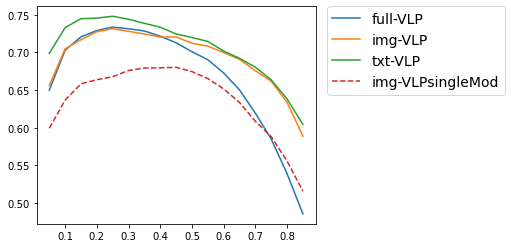

In [1071]:
output_dir = ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/filter_full_data"]*2 + \
            ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/tmp-filter_alone_w_img_20chioces_0527"] + \
            ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/filter_alone_txt_20choices_0528data"]
filenames = [
             "val_-1_step5_img_20_True_True_img_dataset_J_0529-Copy1.txt",
             "val_-1_step5_txt_20_True_txt_dataset_J.txt",
             "val_-1_step6_img_20_True_True_img_dataset_J_0529-Copy1.txt",
             "val_-1_step6_txt_20_True_txt_dataset_J.txt"
            ]
curvenames = ["full-VLP", "img-VLP", "txt-VLP",
              "img-VLPsingleMod", "txt-VLPsingleMod"]
f1_curves = {}
pr_curves = {}
re_curves = {}
th_list = []
for odir, name, c in zip(output_dir, filenames, curvenames):
    f = open(os.path.join(odir, name), "r")
    lines = f.readlines()
    f.close()
    print(c)
    while not "th = " in lines[0]:
        
        lines.pop(0)
    i = 0
    th_list = []
    pr_list = []
    re_list = []
    f1_list = []
    for l in lines:
        if i%5 == 0:
            th_list.append(float(l.strip().split()[-1]))
        elif i%5 == 1:
            pr_list.append(float(l.strip().split()[-1]))
        elif i%5 == 2:
            re_list.append(float(l.strip().split()[-1]))
        elif i%5 == 3:
            f1_list.append(float(l.strip().split()[-1]))
        i += 1
    assert len(th_list) == len(pr_list) == len(re_list) == len(f1_list)
    f1_curves[c] = f1_list
    pr_curves[c] = pr_list
    re_curves[c] = re_list

plt.figure(figsize=(5, 4))
for c in f1_curves:
    if "single" in c:
        plt.plot(th_list[:-2], f1_curves[c][:-2], "--", label=c)
    else: plt.plot(th_list[:-2], f1_curves[c][:-2], label=c)

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)
plt.show()

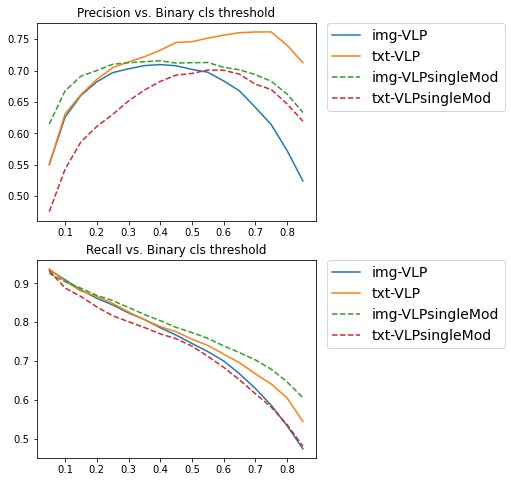

In [994]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,8))
#fig.suptitle('Precision / Recall curves on Val against binary cls threshold', fontsize=18)

for c in pr_curves:
    
    if "single" in c:
        ax1.plot(th_list[:-2], pr_curves[c][:-2], "--", label=c)
    else: ax1.plot(th_list[:-2], pr_curves[c][:-2], label=c)
    ax1.title.set_text("Precision vs. Binary cls threshold")
    ax1.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)
for c in re_curves:
    
    if "single" in c:
        ax2.plot(th_list[:-2], re_curves[c][:-2], "--", label=c)
    else: ax2.plot(th_list[:-2], re_curves[c][:-2], label=c)
    ax2.title.set_text("Recall vs. Binary cls threshold")
    ax2.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)

#plt.show()

In [1069]:
output_dir = "/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/filter_full_data"
filenames = ["val_-1_step5_img_20_True_True_img_dataset_J_0529-Copy1_Top2.txt",
             "val_-1_step5_txt_20_True_txt_dataset_J_Top2.txt",
            ]
f1_curves = []
pr_curves = []
re_curves = []
for f in filenames:
    f = open(os.path.join(output_dir, f), "r")
    lines = f.readlines()
    f.close()
    print(c)
    while not "th = " in lines[0]:
        lines.pop(0)
    i = 0
    th_list = []
    pr_list = []
    re_list = []
    f1_list = []
    for l in lines:
        if i%5 == 0:
            th_list.append(float(l.strip().split()[-1]))
        elif i%5 == 1:
            pr_list.append(float(l.strip().split()[-1]))
        elif i%5 == 2:
            re_list.append(float(l.strip().split()[-1]))
        elif i%5 == 3:
            f1_list.append(float(l.strip().split()[-1]))
        i += 1
    assert len(th_list) == len(pr_list) == len(re_list) == len(f1_list)
    f1_curves.append(f1_list)
    pr_curves.append(pr_list)
    re_curves.append(re_list)
    
i = 0
for th in th_list:
    print(th)
    print((pr_curves[0][i]*2541 + pr_curves[1][i]*793) / (2541+793))
    print((re_curves[0][i]*2541 + re_curves[1][i]*793) / (2541+793))
    print((f1_curves[0][i]*2541 + f1_curves[1][i]*793) / (2541+793))
    print()
    i += 1

img_question_only-VLPsingleMod
img_question_only-VLPsingleMod
0.0
0.6565154193491658
0.8504237192232995
0.7202674201593802

0.05
0.7188019278931799
0.8339271640329802
0.753800037464578

0.1
0.7384476140107451
0.8209298688244241
0.7599086496028624

0.15
0.744546186465731
0.803983395367904
0.7562093745420998

0.2
0.7492950791059935
0.791835920112134
0.7535199082525338

0.25
0.7514945198861819
0.7804382836387387
0.7493807504843655

0.3
0.7494448604025546
0.7670910528340709
0.7423322155663349

0.35
0.7486449265574356
0.7543436870565926
0.7357435746112628

0.4
0.7465952485777816
0.7389968673363049
0.7271153743127564

0.45
0.7429959189446309
0.7242999237240074
0.7178673235056647

0.5
0.7354474180620079
0.7075034105255746
0.7056299063882678

0.55
0.7291486523158547
0.6912067946810182
0.6945822366298874

0.6
0.7168511403184417
0.6713609062742202
0.678355664743123

0.65
0.7023540775644822
0.6463661005670139
0.6584998755943234

0.7
0.6795587371322012
0.6136228996217488
0.6302258761084447

0.75
0

img-VLP-Top2
txt-VLP-Top2
img-VLPsingleMod-Top2
txt-VLPsingleMod-Top2
img-VLP
txt-VLP
img-VLPsingleMod
txt-VLPsingleMod


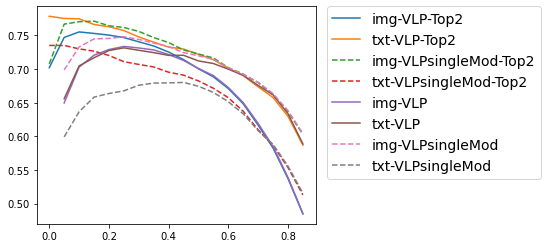

In [1002]:
output_dir = ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/filter_full_data"]*2 + \
            ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/tmp-filter_alone_w_img_20chioces_0527"] + \
            ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/filter_alone_txt_20choices_0528data"] + \
            ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/filter_full_data"]*2 + \
            ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/tmp-filter_alone_w_img_20chioces_0527"] + \
            ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/filter_alone_txt_20choices_0528data"]
filenames = ["val_-1_step5_img_20_True_True_img_dataset_J_0529-Copy1_Top2.txt",
             "val_-1_step5_txt_20_True_txt_dataset_J_Top2.txt",
             "val_-1_step6_img_20_True_True_img_dataset_J_0529-Copy1_Top2.txt",
             "val_-1_step6_txt_20_True_txt_dataset_J_Top2.txt",
             "val_-1_step5_img_20_True_True_img_dataset_J_0529-Copy1.txt",
             "val_-1_step5_txt_20_True_txt_dataset_J.txt",
             "val_-1_step6_img_20_True_True_img_dataset_J_0529-Copy1.txt",
             "val_-1_step6_txt_20_True_txt_dataset_J.txt",
            ]
curvenames = ["img-VLP-Top2", "txt-VLP-Top2", "img-VLPsingleMod-Top2", "txt-VLPsingleMod-Top2"] + \
            ["img-VLP", "txt-VLP", "img-VLPsingleMod", "txt-VLPsingleMod"]
            
f1_curves = {}
pr_curves = {}
re_curves = {}
th_list = []
for odir, name, c in zip(output_dir, filenames, curvenames):
    f = open(os.path.join(odir, name), "r")
    lines = f.readlines()
    f.close()
    print(c)
    while not "th = " in lines[0]:
        
        lines.pop(0)
    i = 0
    th_list = []
    pr_list = []
    re_list = []
    f1_list = []
    for l in lines:
        if i%5 == 0:
            th_list.append(float(l.strip().split()[-1]))
        elif i%5 == 1:
            pr_list.append(float(l.strip().split()[-1]))
        elif i%5 == 2:
            re_list.append(float(l.strip().split()[-1]))
        elif i%5 == 3:
            f1_list.append(float(l.strip().split()[-1]))
        i += 1
    assert len(th_list) == len(pr_list) == len(re_list) == len(f1_list)
    f1_curves[c] = f1_list
    pr_curves[c] = pr_list
    re_curves[c] = re_list

plt.figure(figsize=(5, 4))
th_list = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
for c in f1_curves:
    if "single" in c:
        if len(f1_curves[c])<20:
            plt.plot(th_list[1:-2], f1_curves[c][:-2], "--", label=c)
        else:
            plt.plot(th_list[:-2], f1_curves[c][:-2], "--", label=c)
        
    else: 
        if len(f1_curves[c])<20:
            plt.plot(th_list[1:-2], f1_curves[c][:-2], label=c)
        else:
            plt.plot(th_list[:-2], f1_curves[c][:-2], label=c)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)
plt.show()

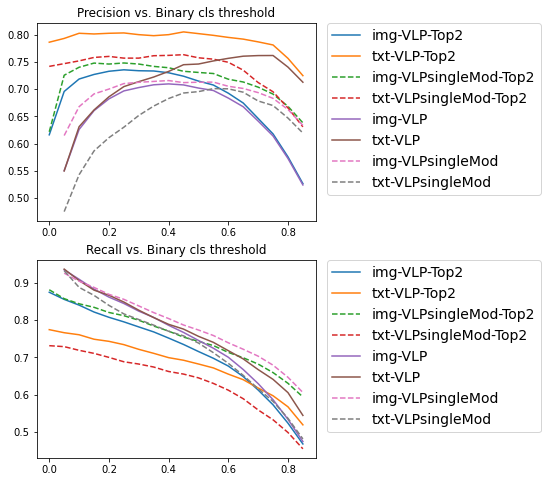

In [1005]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,8))
#fig.suptitle('Precision / Recall curves on Val against binary cls threshold', fontsize=18)

for c in pr_curves:
    
    if "single" in c:
        if len(pr_curves[c])<20:
            ax1.plot(th_list[1:-2], pr_curves[c][:-2], "--", label=c)
        else:
            ax1.plot(th_list[:-2], pr_curves[c][:-2], "--", label=c)
            
    else: 
        if len(pr_curves[c])<20:
            ax1.plot(th_list[1:-2], pr_curves[c][:-2], label=c)
        else:
            ax1.plot(th_list[:-2], pr_curves[c][:-2], label=c)
    
    ax1.title.set_text("Precision vs. Binary cls threshold")
    ax1.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)
for c in re_curves:
    
    if "single" in c:
        if len(re_curves[c])<20:
            ax2.plot(th_list[1:-2], re_curves[c][:-2], "--", label=c)
        else:
            ax2.plot(th_list[:-2], re_curves[c][:-2], "--", label=c)
    
    else: 
        if len(re_curves[c])<20:
            ax2.plot(th_list[1:-2], re_curves[c][:-2], label=c)
        else:
            ax2.plot(th_list[:-2], re_curves[c][:-2], label=c)
    ax2.title.set_text("Recall vs. Binary cls threshold")
    ax2.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)

#plt.show()

full-VLP
img-VLP
txt-VLP
img-VLPsingleMod
txt-VLPsingleMod


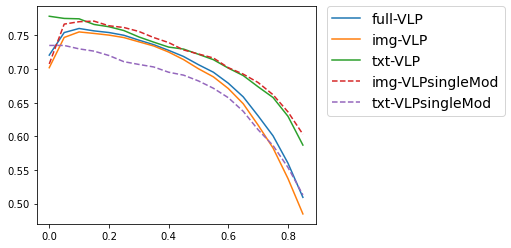

In [1073]:
output_dir = ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/filter_full_data"]*3 + \
            ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/tmp-filter_alone_w_img_20chioces_0527"] + \
            ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/filter_alone_txt_20choices_0528data"]
filenames = ["val_-1_step5_img_20_True_True_txt_20_True_img_dataset_J_0529-Copy1_txt_dataset_J_Top2.txt",
             "val_-1_step5_img_20_True_True_img_dataset_J_0529-Copy1_Top2.txt",
             "val_-1_step5_txt_20_True_txt_dataset_J_Top2.txt",
             "val_-1_step6_img_20_True_True_img_dataset_J_0529-Copy1_Top2.txt",
             "val_-1_step6_txt_20_True_txt_dataset_J_Top2.txt"
            ]
curvenames = ["full-VLP", "img-VLP", "txt-VLP",
              "img-VLPsingleMod", "txt-VLPsingleMod"]
f1_curves = {}
pr_curves = {}
re_curves = {}
th_list = []
for odir, name, c in zip(output_dir, filenames, curvenames):
    f = open(os.path.join(odir, name), "r")
    lines = f.readlines()
    f.close()
    print(c)
    while not "th = " in lines[0]:
        
        lines.pop(0)
    i = 0
    th_list = []
    pr_list = []
    re_list = []
    f1_list = []
    for l in lines:
        if i%5 == 0:
            th_list.append(float(l.strip().split()[-1]))
        elif i%5 == 1:
            pr_list.append(float(l.strip().split()[-1]))
        elif i%5 == 2:
            re_list.append(float(l.strip().split()[-1]))
        elif i%5 == 3:
            f1_list.append(float(l.strip().split()[-1]))
        i += 1
    assert len(th_list) == len(pr_list) == len(re_list) == len(f1_list)
    f1_curves[c] = f1_list
    pr_curves[c] = pr_list
    re_curves[c] = re_list

plt.figure(figsize=(5, 4))
for c in f1_curves:
    if "single" in c:
        plt.plot(th_list[:-2], f1_curves[c][:-2], "--", label=c)
    else: plt.plot(th_list[:-2], f1_curves[c][:-2], label=c)

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)
plt.show()

img-VLP
img_no_meta-VLP
img_no_content-VLP
img_question_only-VLP
img-VLPsingleMod
img_no_meta-VLPsingleMod
img_no_content-VLPsingleMod
img_question_only-VLPsingleMod


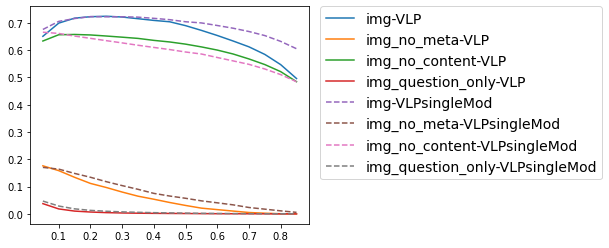

In [1047]:
output_dir = ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/filter_full_data"]*4 + \
            ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/tmp-filter_alone_w_img_20chioces_0527"]*4
filenames = ["ind_test|ood_test_-1_step5_img_20_True_True_img_dataset_J_0529-Copy1.txt",
             "ind_test|ood_test_-1_step5_img_20_True_False_img_dataset_J_0529-Copy1.txt",
             "ind_test|ood_test_-1_step5_img_20_False_True_img_dataset_J_0529-Copy1.txt",
             "ind_test|ood_test_-1_step5_img_20_False_False_img_dataset_J_0529-Copy1.txt",
             "ind_test|ood_test_-1_step6_img_20_True_True_img_dataset_J_0529-Copy1.txt",
             "ind_test|ood_test_-1_step6_img_20_True_False_img_dataset_J_0529-Copy1.txt",
             "ind_test|ood_test_-1_step6_img_20_False_True_img_dataset_J_0529-Copy1.txt",
             "ind_test|ood_test_-1_step6_img_20_False_False_img_dataset_J_0529-Copy1.txt",
             
            ]
curvenames = ["img-VLP", "img_no_meta-VLP", "img_no_content-VLP", "img_question_only-VLP",
              "img-VLPsingleMod", "img_no_meta-VLPsingleMod", "img_no_content-VLPsingleMod", "img_question_only-VLPsingleMod"]
f1_curves = {}
pr_curves = {}
re_curves = {}
th_list = []
for odir, name, c in zip(output_dir, filenames, curvenames):
    f = open(os.path.join(odir, name), "r")
    lines = f.readlines()
    f.close()
    print(c)
    while not "th = " in lines[0]:
        
        lines.pop(0)
    i = 0
    th_list = []
    pr_list = []
    re_list = []
    f1_list = []
    for l in lines:
        if i%5 == 0:
            th_list.append(float(l.strip().split()[-1]))
        elif i%5 == 1:
            pr_list.append(float(l.strip().split()[-1]))
        elif i%5 == 2:
            re_list.append(float(l.strip().split()[-1]))
        elif i%5 == 3:
            f1_list.append(float(l.strip().split()[-1]))
        i += 1
    assert len(th_list) == len(pr_list) == len(re_list) == len(f1_list)
    f1_curves[c] = f1_list
    pr_curves[c] = pr_list
    re_curves[c] = re_list
    
plt.figure(figsize=(5, 4))
for c in f1_curves:
    if 'single' in c: plt.plot(th_list[:-2], f1_curves[c][:-2], '--', label=c)
    else: plt.plot(th_list[:-2], f1_curves[c][:-2], label=c)

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)
plt.show()

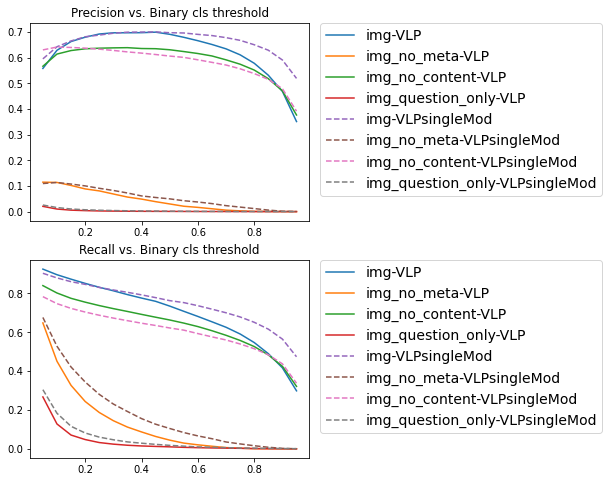

In [1049]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,8))
#fig.suptitle('Precision / Recall curves on Val against binary cls threshold', fontsize=18)

for c in pr_curves:
    if 'single' in c:
        ax1.plot(th_list, pr_curves[c], '--', label=c)
    else:
        ax1.plot(th_list, pr_curves[c], label=c)
    ax1.title.set_text("Precision vs. Binary cls threshold")
    ax1.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)
for c in re_curves:
    if 'single' in c:
        ax2.plot(th_list, re_curves[c], '--', label=c)
    else:
        ax2.plot(th_list, re_curves[c], label=c)
    ax2.title.set_text("Recall vs. Binary cls threshold")
    ax2.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)

#plt.show()

img-VLP
img_no_meta-VLP
img_no_content-VLP
img_question_only-VLP
img-VLPsingleMod
img_no_meta-VLPsingleMod
img_no_content-VLPsingleMod
img_question_only-VLPsingleMod


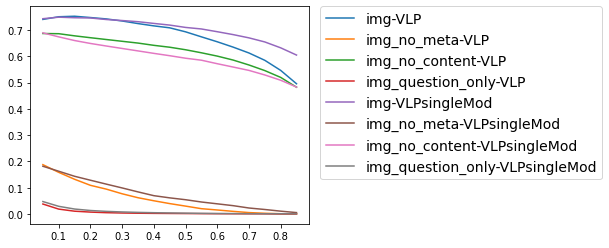

In [1019]:
output_dir = ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/filter_full_data"]*4 + \
            ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/tmp-filter_alone_w_img_20chioces_0527"]*4
filenames = ["ind_test|ood_test_-1_step5_img_20_True_True_img_dataset_J_0529-Copy1_Top2.txt",
             "ind_test|ood_test_-1_step5_img_20_True_False_img_dataset_J_0529-Copy1_Top2.txt",
             "ind_test|ood_test_-1_step5_img_20_False_True_img_dataset_J_0529-Copy1_Top2.txt",
             "ind_test|ood_test_-1_step5_img_20_False_False_img_dataset_J_0529-Copy1_Top2.txt",
             "ind_test|ood_test_-1_step6_img_20_True_True_img_dataset_J_0529-Copy1_Top2.txt",
             "ind_test|ood_test_-1_step6_img_20_True_False_img_dataset_J_0529-Copy1_Top2.txt",
             "ind_test|ood_test_-1_step6_img_20_False_True_img_dataset_J_0529-Copy1_Top2.txt",
             "ind_test|ood_test_-1_step6_img_20_False_False_img_dataset_J_0529-Copy1_Top2.txt",
             
            ]
curvenames = ["img-VLP", "img_no_meta-VLP", "img_no_content-VLP", "img_question_only-VLP",
              "img-VLPsingleMod", "img_no_meta-VLPsingleMod", "img_no_content-VLPsingleMod", "img_question_only-VLPsingleMod"]
f1_curves = {}
pr_curves = {}
re_curves = {}
th_list = []
for odir, name, c in zip(output_dir, filenames, curvenames):
    f = open(os.path.join(odir, name), "r")
    lines = f.readlines()
    f.close()
    print(c)
    while not "th = " in lines[0]:
        
        lines.pop(0)
    i = 0
    th_list = []
    pr_list = []
    re_list = []
    f1_list = []
    for l in lines:
        if i%5 == 0:
            th_list.append(float(l.strip().split()[-1]))
        elif i%5 == 1:
            pr_list.append(float(l.strip().split()[-1]))
        elif i%5 == 2:
            re_list.append(float(l.strip().split()[-1]))
        elif i%5 == 3:
            f1_list.append(float(l.strip().split()[-1]))
        i += 1
    assert len(th_list) == len(pr_list) == len(re_list) == len(f1_list)
    f1_curves[c] = f1_list
    pr_curves[c] = pr_list
    re_curves[c] = re_list
    
plt.figure(figsize=(5, 4))
for c in f1_curves:
    
    plt.plot(th_list[1:-2], f1_curves[c][1:-2], label=c)

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)
plt.show()

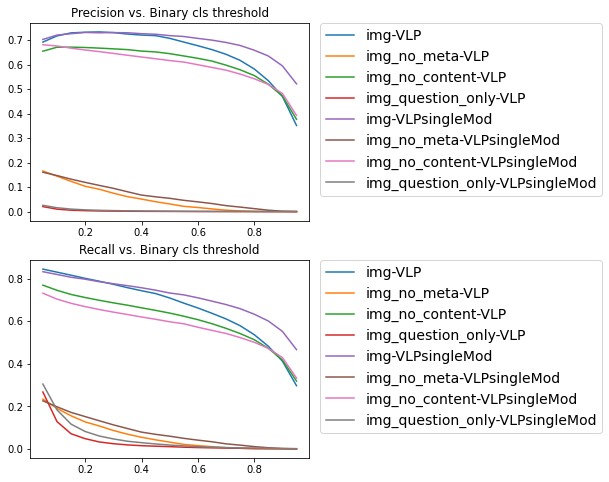

In [1020]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,8))
#fig.suptitle('Precision / Recall curves on Val against binary cls threshold', fontsize=18)

for c in pr_curves:
    if 'single' in c:
        ax1.plot(th_list[1:], pr_curves[c][1:], '--', label=c)
    else:
        ax1.plot(th_list[1:], pr_curves[c][1:], label=c)
    ax1.title.set_text("Precision vs. Binary cls threshold")
    ax1.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)
for c in re_curves:
    if 'single' in c:
        ax2.plot(th_list[1:], re_curves[c][1:], '--', label=c)
    else:
        ax2.plot(th_list[1:], re_curves[c][1:], label=c)
    ax2.title.set_text("Recall vs. Binary cls threshold")
    ax2.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)

#plt.show()

img-VLP-yes_no
img-VLP-nonbinary
img-VLPsingleMod-yes_no
img-VLPsingleMod-nonbinary


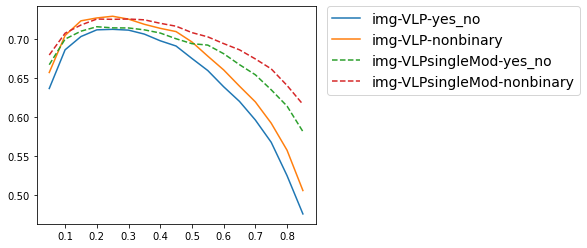

In [1024]:
output_dir = ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/filter_full_data"]*2 + \
            ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/tmp-filter_alone_w_img_20chioces_0527"]*2 #+ \
            #["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/tmp-filter_alone_w_img_20chioces_0527"]
filenames = ["ind_test|ood_test_-1_step5_img_20_True_True_img_yes_no.txt",
             "ind_test|ood_test_-1_step5_img_20_True_True_img_nonbinary.txt",
             #"ind_test|ood_test_-1_step5_img_20_False_True_img_dataset_J_0529-Copy1.txt",
             #"ind_test|ood_test_-1_step5_img_20_False_False_img_dataset_J_0529-Copy1.txt",
             "ind_test|ood_test_-1_step6_img_20_True_True_img_yes_no.txt",
             "ind_test|ood_test_-1_step6_img_20_True_True_img_nonbinary.txt",
             #"ind_test|ood_test_-1_step6_img_20_False_True_img_dataset_J_0529-Copy1.txt",
             #"ind_test|ood_test_-1_step6_img_20_False_False_img_dataset_J_0529-Copy1.txt",
            ]
curvenames = ["img-VLP-yes_no", "img-VLP-nonbinary", #"img_no_content-VLP", "img_question_only-VLP",
              "img-VLPsingleMod-yes_no", "img-VLPsingleMod-nonbinary", #"img_no_content-VLPsingleMod", "img_question_only-VLPsingleMod"
             ]
f1_curves = {}
pr_curves = {}
re_curves = {}
th_list = []
for odir, name, c in zip(output_dir, filenames, curvenames):
    f = open(os.path.join(odir, name), "r")
    lines = f.readlines()
    f.close()
    print(c)
    while not "th = " in lines[0]:
        
        lines.pop(0)
    i = 0
    th_list = []
    pr_list = []
    re_list = []
    f1_list = []
    for l in lines:
        if i%5 == 0:
            th_list.append(float(l.strip().split()[-1]))
        elif i%5 == 1:
            pr_list.append(float(l.strip().split()[-1]))
        elif i%5 == 2:
            re_list.append(float(l.strip().split()[-1]))
        elif i%5 == 3:
            f1_list.append(float(l.strip().split()[-1]))
        i += 1
    assert len(th_list) == len(pr_list) == len(re_list) == len(f1_list)
    f1_curves[c] = f1_list
    pr_curves[c] = pr_list
    re_curves[c] = re_list
plt.figure(figsize=(5, 4))
for c in f1_curves:
    if "single" in c:
        plt.plot(th_list[:-2], f1_curves[c][:-2], '--', label=c)
    else:
        plt.plot(th_list[:-2], f1_curves[c][:-2], label=c)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)
plt.show()

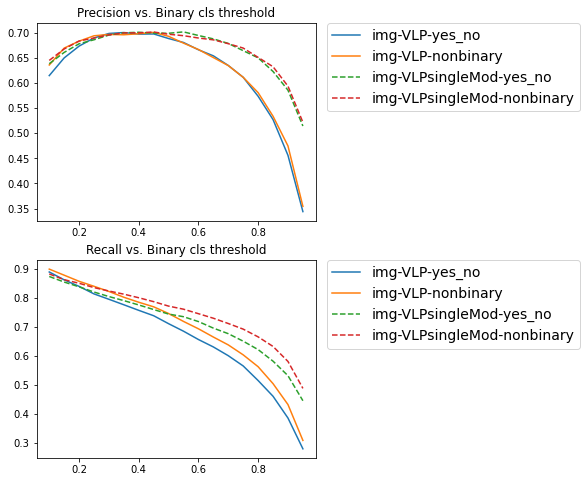

In [1026]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,8))
#fig.suptitle('Precision / Recall curves on Val against binary cls threshold', fontsize=18)

for c in pr_curves:
    if 'single' in c:
        ax1.plot(th_list[1:], pr_curves[c][1:], '--', label=c)
    else:
        ax1.plot(th_list[1:], pr_curves[c][1:], label=c)
    ax1.title.set_text("Precision vs. Binary cls threshold")
    ax1.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)
for c in re_curves:
    if 'single' in c:
        ax2.plot(th_list[1:], re_curves[c][1:], '--', label=c)
    else:
        ax2.plot(th_list[1:], re_curves[c][1:], label=c)
    ax2.title.set_text("Recall vs. Binary cls threshold")
    ax2.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)

#plt.show()

img-VLP-yes_no
img-VLP-nonbinary
img-VLPsingleMod-yes_no
img-VLPsingleMod-nonbinary


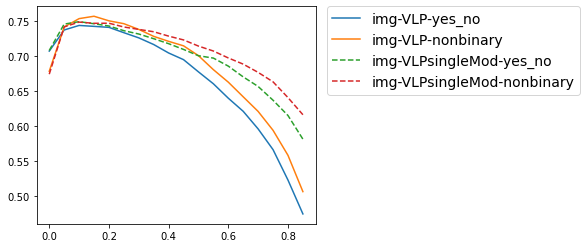

In [1027]:
output_dir = ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/filter_full_data"]*2 + \
            ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/tmp-filter_alone_w_img_20chioces_0527"]*2 #+ \
            #["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/tmp-filter_alone_w_img_20chioces_0527"]
filenames = ["ind_test|ood_test_-1_step5_img_20_True_True_img_yes_no_Top2.txt",
             "ind_test|ood_test_-1_step5_img_20_True_True_img_nonbinary_Top2.txt",
             #"ind_test|ood_test_-1_step5_img_20_False_True_img_dataset_J_0529-Copy1.txt",
             #"ind_test|ood_test_-1_step5_img_20_False_False_img_dataset_J_0529-Copy1.txt",
             "ind_test|ood_test_-1_step6_img_20_True_True_img_yes_no_Top2.txt",
             "ind_test|ood_test_-1_step6_img_20_True_True_img_nonbinary_Top2.txt",
             #"ind_test|ood_test_-1_step6_img_20_False_True_img_dataset_J_0529-Copy1.txt",
             #"ind_test|ood_test_-1_step6_img_20_False_False_img_dataset_J_0529-Copy1.txt",
            ]
curvenames = ["img-VLP-yes_no", "img-VLP-nonbinary", #"img_no_content-VLP", "img_question_only-VLP",
              "img-VLPsingleMod-yes_no", "img-VLPsingleMod-nonbinary", #"img_no_content-VLPsingleMod", "img_question_only-VLPsingleMod"
             ]
f1_curves = {}
pr_curves = {}
re_curves = {}
th_list = []
for odir, name, c in zip(output_dir, filenames, curvenames):
    f = open(os.path.join(odir, name), "r")
    lines = f.readlines()
    f.close()
    print(c)
    while not "th = " in lines[0]:
        
        lines.pop(0)
    i = 0
    th_list = []
    pr_list = []
    re_list = []
    f1_list = []
    for l in lines:
        if i%5 == 0:
            th_list.append(float(l.strip().split()[-1]))
        elif i%5 == 1:
            pr_list.append(float(l.strip().split()[-1]))
        elif i%5 == 2:
            re_list.append(float(l.strip().split()[-1]))
        elif i%5 == 3:
            f1_list.append(float(l.strip().split()[-1]))
        i += 1
    assert len(th_list) == len(pr_list) == len(re_list) == len(f1_list)
    f1_curves[c] = f1_list
    pr_curves[c] = pr_list
    re_curves[c] = re_list
plt.figure(figsize=(5, 4))
for c in f1_curves:
    if "single" in c:
        plt.plot(th_list[:-2], f1_curves[c][:-2], '--', label=c)
    else:
        plt.plot(th_list[:-2], f1_curves[c][:-2], label=c)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)
plt.show()

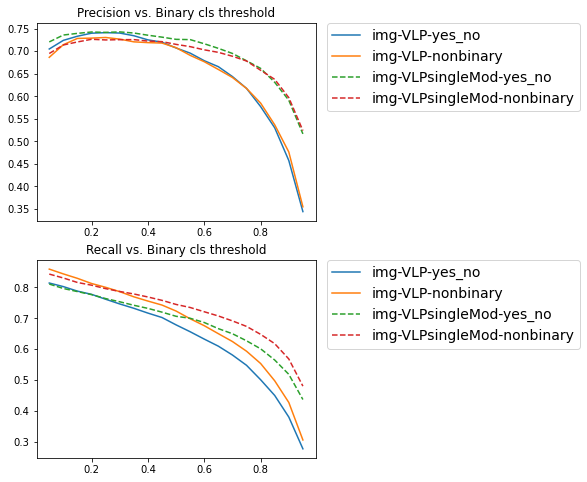

In [1028]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,8))
#fig.suptitle('Precision / Recall curves on Val against binary cls threshold', fontsize=18)

for c in pr_curves:
    if 'single' in c:
        ax1.plot(th_list[1:], pr_curves[c][1:], '--', label=c)
    else:
        ax1.plot(th_list[1:], pr_curves[c][1:], label=c)
    ax1.title.set_text("Precision vs. Binary cls threshold")
    ax1.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)
for c in re_curves:
    if 'single' in c:
        ax2.plot(th_list[1:], re_curves[c][1:], '--', label=c)
    else:
        ax2.plot(th_list[1:], re_curves[c][1:], label=c)
    ax2.title.set_text("Recall vs. Binary cls threshold")
    ax2.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)

#plt.show()

img-VLP-1gold
img-VLP-2golds
img-VLP-2golds_necessary
img-VLPsingleMod-1gold
img-VLPsingleMod-2golds
img-VLPsingleMod-2golds_necessary


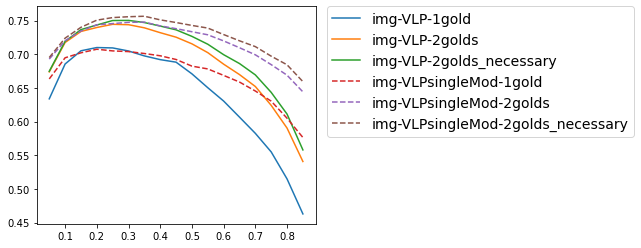

In [1029]:
output_dir = ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/filter_full_data"]*3 + \
            ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/tmp-filter_alone_w_img_20chioces_0527"]*3 #+ \
            #["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/tmp-filter_alone_w_img_20chioces_0527"]
filenames = ["ind_test|ood_test_-1_step5_img_20_True_True_img_1gold.txt",
             "ind_test|ood_test_-1_step5_img_20_True_True_img_2golds.txt",
             "ind_test|ood_test_-1_step5_img_20_True_True_dataset_J_img_multihop.txt",
             #"ind_test|ood_test_-1_step5_img_20_False_False_img_dataset_J_0529-Copy1.txt",
             "ind_test|ood_test_-1_step6_img_20_True_True_img_1gold.txt",
             "ind_test|ood_test_-1_step6_img_20_True_True_img_2golds.txt",
             "ind_test|ood_test_-1_step6_img_20_True_True_dataset_J_img_multihop.txt",
             #"ind_test|ood_test_-1_step6_img_20_False_False_img_dataset_J_0529-Copy1.txt",
            ]
curvenames = ["img-VLP-1gold", "img-VLP-2golds", "img-VLP-2golds_necessary", #"img_question_only-VLP",
              "img-VLPsingleMod-1gold", "img-VLPsingleMod-2golds", "img-VLPsingleMod-2golds_necessary", #"img_question_only-VLPsingleMod"
             ]
f1_curves = {}
pr_curves = {}
re_curves = {}
th_list = []
for odir, name, c in zip(output_dir, filenames, curvenames):
    f = open(os.path.join(odir, name), "r")
    lines = f.readlines()
    f.close()
    print(c)
    while not "th = " in lines[0]:
        
        lines.pop(0)
    i = 0
    th_list = []
    pr_list = []
    re_list = []
    f1_list = []
    for l in lines:
        if i%5 == 0:
            th_list.append(float(l.strip().split()[-1]))
        elif i%5 == 1:
            pr_list.append(float(l.strip().split()[-1]))
        elif i%5 == 2:
            re_list.append(float(l.strip().split()[-1]))
        elif i%5 == 3:
            f1_list.append(float(l.strip().split()[-1]))
        i += 1
    assert len(th_list) == len(pr_list) == len(re_list) == len(f1_list)
    f1_curves[c] = f1_list
    pr_curves[c] = pr_list
    re_curves[c] = re_list
    
plt.figure(figsize=(5, 4))
for c in f1_curves:
    if "single" in c:
        plt.plot(th_list[:-2], f1_curves[c][:-2], '--', label=c)
    else:
        plt.plot(th_list[:-2], f1_curves[c][:-2], label=c)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)
plt.show()

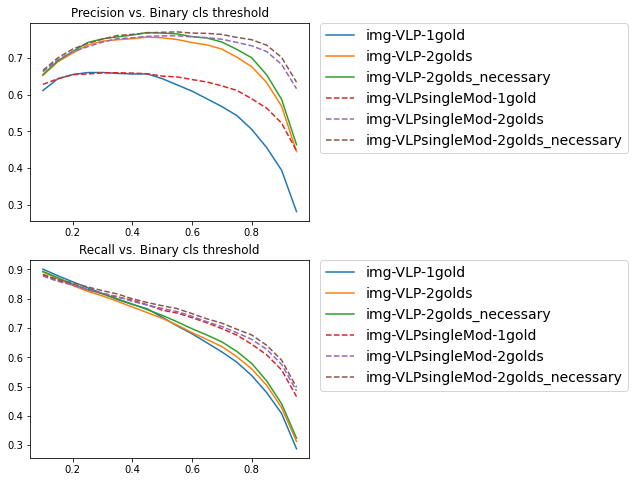

In [1030]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,8))
#fig.suptitle('Precision / Recall curves on Val against binary cls threshold', fontsize=18)

for c in pr_curves:
    if 'single' in c:
        ax1.plot(th_list[1:], pr_curves[c][1:], '--', label=c)
    else:
        ax1.plot(th_list[1:], pr_curves[c][1:], label=c)
    ax1.title.set_text("Precision vs. Binary cls threshold")
    ax1.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)
for c in re_curves:
    if 'single' in c:
        ax2.plot(th_list[1:], re_curves[c][1:], '--', label=c)
    else:
        ax2.plot(th_list[1:], re_curves[c][1:], label=c)
    ax2.title.set_text("Recall vs. Binary cls threshold")
    ax2.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)

#plt.show()

img-VLP-1gold
img-VLP-2golds
img-VLP-2golds_necessary
img-VLPsingleMod-1gold
img-VLPsingleMod-2golds
img-VLPsingleMod-2golds_necessary


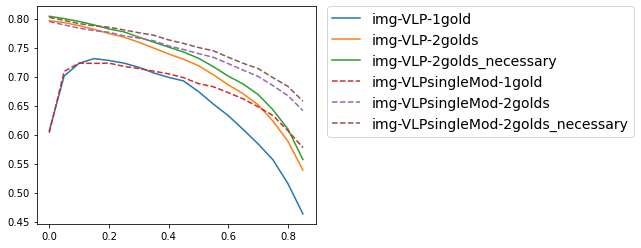

In [1031]:
output_dir = ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/filter_full_data"]*3 + \
            ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/tmp-filter_alone_w_img_20chioces_0527"]*3 #+ \
            #["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/tmp-filter_alone_w_img_20chioces_0527"]
filenames = ["ind_test|ood_test_-1_step5_img_20_True_True_img_1gold_Top2.txt",
             "ind_test|ood_test_-1_step5_img_20_True_True_img_2golds_Top2.txt",
             "ind_test|ood_test_-1_step5_img_20_True_True_dataset_J_img_multihop_Top2.txt",
             #"ind_test|ood_test_-1_step5_img_20_False_False_img_dataset_J_0529-Copy1.txt",
             "ind_test|ood_test_-1_step6_img_20_True_True_img_1gold_Top2.txt",
             "ind_test|ood_test_-1_step6_img_20_True_True_img_2golds_Top2.txt",
             "ind_test|ood_test_-1_step6_img_20_True_True_dataset_J_img_multihop_Top2.txt",
             #"ind_test|ood_test_-1_step6_img_20_False_False_img_dataset_J_0529-Copy1.txt",
            ]
curvenames = ["img-VLP-1gold", "img-VLP-2golds", "img-VLP-2golds_necessary", #"img_question_only-VLP",
              "img-VLPsingleMod-1gold", "img-VLPsingleMod-2golds", "img-VLPsingleMod-2golds_necessary", #"img_question_only-VLPsingleMod"
             ]
f1_curves = {}
pr_curves = {}
re_curves = {}
th_list = []
for odir, name, c in zip(output_dir, filenames, curvenames):
    f = open(os.path.join(odir, name), "r")
    lines = f.readlines()
    f.close()
    print(c)
    while not "th = " in lines[0]:
        
        lines.pop(0)
    i = 0
    th_list = []
    pr_list = []
    re_list = []
    f1_list = []
    for l in lines:
        if i%5 == 0:
            th_list.append(float(l.strip().split()[-1]))
        elif i%5 == 1:
            pr_list.append(float(l.strip().split()[-1]))
        elif i%5 == 2:
            re_list.append(float(l.strip().split()[-1]))
        elif i%5 == 3:
            f1_list.append(float(l.strip().split()[-1]))
        i += 1
    assert len(th_list) == len(pr_list) == len(re_list) == len(f1_list)
    f1_curves[c] = f1_list
    pr_curves[c] = pr_list
    re_curves[c] = re_list
    
plt.figure(figsize=(5, 4))
for c in f1_curves:
    if "single" in c:
        plt.plot(th_list[:-2], f1_curves[c][:-2], '--', label=c)
    else:
        plt.plot(th_list[:-2], f1_curves[c][:-2], label=c)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)
plt.show()

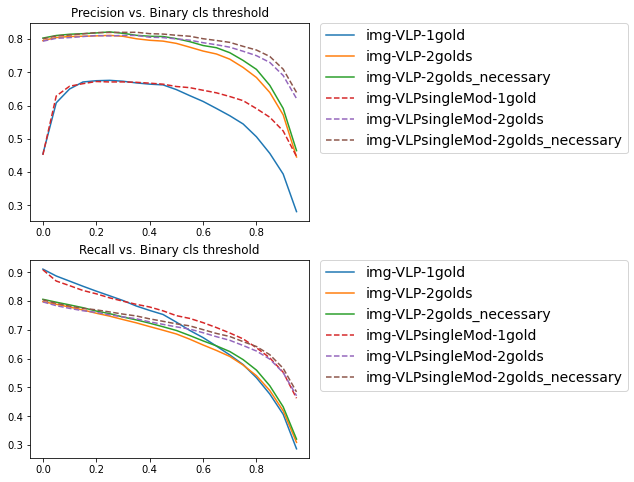

In [1034]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,8))
#fig.suptitle('Precision / Recall curves on Val against binary cls threshold', fontsize=18)

for c in pr_curves:
    if 'single' in c:
        ax1.plot(th_list, pr_curves[c], '--', label=c)
    else:
        ax1.plot(th_list, pr_curves[c], label=c)
    ax1.title.set_text("Precision vs. Binary cls threshold")
    ax1.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)
for c in re_curves:
    if 'single' in c:
        ax2.plot(th_list, re_curves[c], '--', label=c)
    else:
        ax2.plot(th_list, re_curves[c], label=c)
    ax2.title.set_text("Recall vs. Binary cls threshold")
    ax2.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)

#plt.show()

txt-VLP
txt_question_only-VLP
txt-VLPsingleMod
txt_question_only_VLPsingleMod


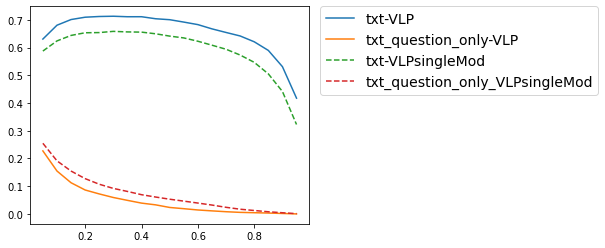

In [1037]:
output_dir = ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/filter_full_data"]*2 + \
            ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/filter_alone_txt_20choices_0528data"]*2
            
filenames = ["ind_test|ood_test_-1_step5_txt_20_True_txt_dataset_J.txt",
            "ind_test|ood_test_-1_step5_txt_20_False_txt_dataset_J.txt",
            "ind_test|ood_test_-1_step6_txt_20_True_txt_dataset_J.txt",
            "ind_test|ood_test_-1_step6_txt_20_False_txt_dataset_J.txt",]
curvenames = ["txt-VLP", "txt_question_only-VLP", 
             "txt-VLPsingleMod", "txt_question_only_VLPsingleMod"]
f1_curves = {}
pr_curves = {}
re_curves = {}
th_list = []
for odir, name, c in zip(output_dir, filenames, curvenames):
    f = open(os.path.join(odir, name), "r")
    lines = f.readlines()
    f.close()
    print(c)
    while not "th = " in lines[0]:
        
        lines.pop(0)
    i = 0
    th_list = []
    pr_list = []
    re_list = []
    f1_list = []
    for l in lines:
        if i%5 == 0:
            th_list.append(float(l.strip().split()[-1]))
        elif i%5 == 1:
            pr_list.append(float(l.strip().split()[-1]))
        elif i%5 == 2:
            re_list.append(float(l.strip().split()[-1]))
        elif i%5 == 3:
            f1_list.append(float(l.strip().split()[-1]))
        i += 1
    assert len(th_list) == len(pr_list) == len(re_list) == len(f1_list)
    f1_curves[c] = f1_list
    pr_curves[c] = pr_list
    re_curves[c] = re_list

plt.figure(figsize=(5, 4))
for c in f1_curves:
    if "single" in c:
        plt.plot(th_list, f1_curves[c], '--', label=c)
    else:
        plt.plot(th_list, f1_curves[c], label=c)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)
plt.show()

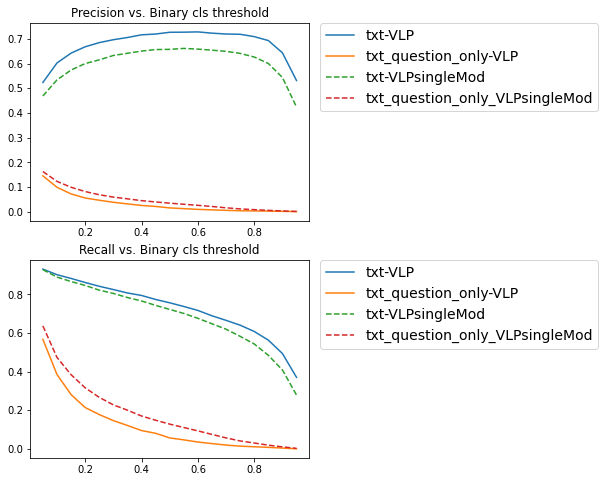

In [1038]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,8))
#fig.suptitle('Precision / Recall curves on Val against binary cls threshold', fontsize=18)

for c in pr_curves:
    if 'single' in c:
        ax1.plot(th_list, pr_curves[c], '--', label=c)
    else:
        ax1.plot(th_list, pr_curves[c], label=c)
    ax1.title.set_text("Precision vs. Binary cls threshold")
    ax1.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)
for c in re_curves:
    if 'single' in c:
        ax2.plot(th_list, re_curves[c], '--', label=c)
    else:
        ax2.plot(th_list, re_curves[c], label=c)
    ax2.title.set_text("Recall vs. Binary cls threshold")
    ax2.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)

#plt.show()

txt-VLP
txt-VLP-Top2
txt-VLP-Top3
txt-VLP-Top4
txt-VLPsingleMod
txt-VLPsingleMod-Top2
txt-VLPsingleMod-Top3
txt-VLPsingleMod-Top4


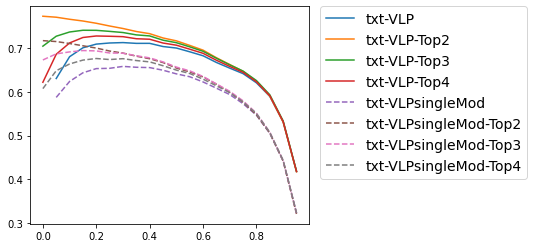

In [1044]:
output_dir = ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/filter_full_data"]*4 + \
            ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/filter_alone_txt_20choices_0528data"]*4
            
filenames = ["ind_test|ood_test_-1_step5_txt_20_True_txt_dataset_J.txt",
            "ind_test|ood_test_-1_step5_txt_20_True_txt_dataset_J_Top2.txt",
             "ind_test|ood_test_-1_step5_txt_20_True_txt_dataset_J_Top3.txt",
             "ind_test|ood_test_-1_step5_txt_20_True_txt_dataset_J_Top4.txt",
            "ind_test|ood_test_-1_step6_txt_20_True_txt_dataset_J.txt",
             "ind_test|ood_test_-1_step6_txt_20_True_txt_dataset_J_Top2.txt",
             "ind_test|ood_test_-1_step6_txt_20_True_txt_dataset_J_Top3.txt",
            "ind_test|ood_test_-1_step6_txt_20_True_txt_dataset_J_Top4.txt",]
curvenames = ["txt-VLP", "txt-VLP-Top2", "txt-VLP-Top3", "txt-VLP-Top4", 
             "txt-VLPsingleMod", "txt-VLPsingleMod-Top2", "txt-VLPsingleMod-Top3", "txt-VLPsingleMod-Top4", 
             ]
f1_curves = {}
pr_curves = {}
re_curves = {}
th_list = []
for odir, name, c in zip(output_dir, filenames, curvenames):
    f = open(os.path.join(odir, name), "r")
    lines = f.readlines()
    f.close()
    print(c)
    while not "th = " in lines[0]:
        
        lines.pop(0)
    i = 0
    th_list = []
    pr_list = []
    re_list = []
    f1_list = []
    for l in lines:
        if i%5 == 0:
            th_list.append(float(l.strip().split()[-1]))
        elif i%5 == 1:
            pr_list.append(float(l.strip().split()[-1]))
        elif i%5 == 2:
            re_list.append(float(l.strip().split()[-1]))
        elif i%5 == 3:
            f1_list.append(float(l.strip().split()[-1]))
        i += 1
    assert len(th_list) == len(pr_list) == len(re_list) == len(f1_list)
    f1_curves[c] = f1_list
    pr_curves[c] = pr_list
    re_curves[c] = re_list

th_list = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
plt.figure(figsize=(5, 4))
for c in f1_curves:
    if "single" in c:
        if len(f1_curves[c]) <20:
            plt.plot(th_list[1:], f1_curves[c], '--', label=c)
        else: plt.plot(th_list, f1_curves[c], '--', label=c)
    else:
        if len(f1_curves[c]) <20:
            plt.plot(th_list[1:], f1_curves[c], label=c)
        else: plt.plot(th_list, f1_curves[c], label=c)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)
plt.show()

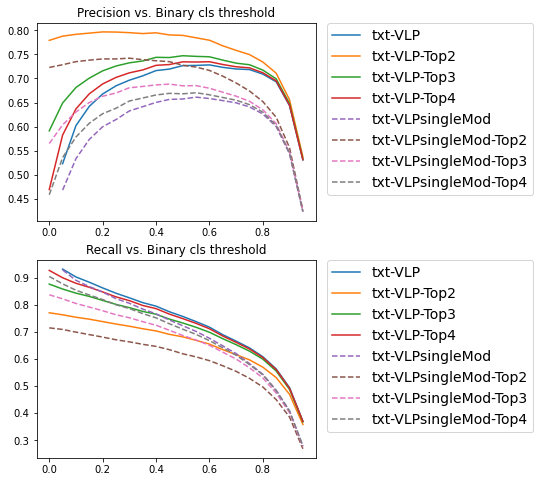

In [1046]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,8))
#fig.suptitle('Precision / Recall curves on Val against binary cls threshold', fontsize=18)

for c in pr_curves:
    if 'single' in c:
        if len(f1_curves[c]) <20:
            ax1.plot(th_list[1:], pr_curves[c], '--', label=c)
        else: ax1.plot(th_list, pr_curves[c], '--', label=c)
    else:
        if len(f1_curves[c]) <20:
            ax1.plot(th_list[1:], pr_curves[c], label=c)
        else: ax1.plot(th_list, pr_curves[c], label=c)
    ax1.title.set_text("Precision vs. Binary cls threshold")
    ax1.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)
for c in re_curves:
    if 'single' in c:
        if len(f1_curves[c]) <20:
            ax2.plot(th_list[1:], re_curves[c], '--', label=c)
        else: ax2.plot(th_list, re_curves[c], '--', label=c)
    else:
        if len(f1_curves[c]) <20:
            ax2.plot(th_list[1:], re_curves[c], label=c)
        else: ax2.plot(th_list, re_curves[c], label=c)
    ax2.title.set_text("Recall vs. Binary cls threshold")
    ax2.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)

#plt.show()

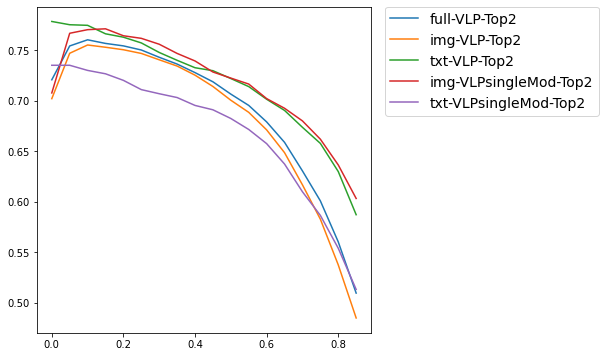

In [924]:
plt.figure(figsize=(6, 6))
for c in f1_curves:
    if len(f1_curves[c])<20:
        plt.plot(th_list[1:-2], f1_curves[c][:-2], label=c)
    else:
        plt.plot(th_list[:-2], f1_curves[c][:-2], label=c)

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)
plt.show()

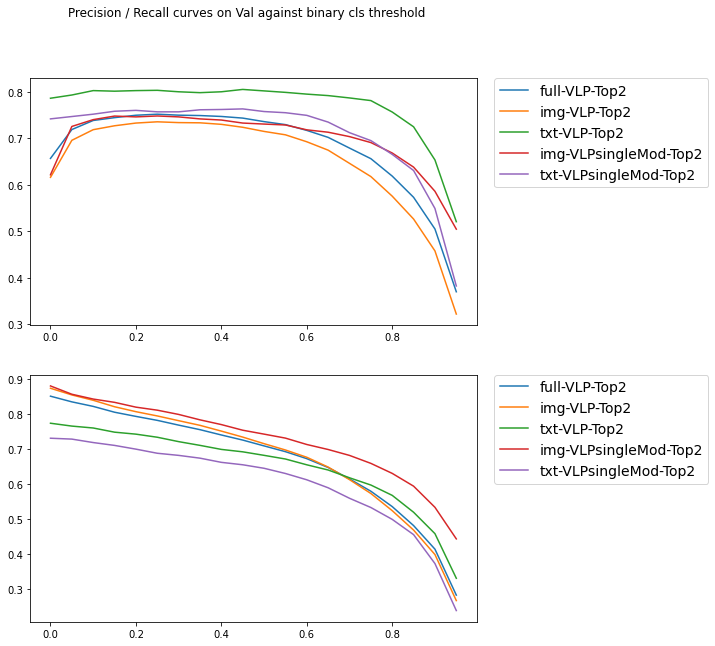

<Figure size 864x432 with 0 Axes>

In [925]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10))
fig.suptitle('Precision / Recall curves on Val against binary cls threshold')

plt.figure(figsize=(12, 6))
for c in pr_curves:
    if len(f1_curves[c])<20:
        ax1.plot(th_list[-19:], pr_curves[c][-19:], label=c)
    else:
        ax1.plot(th_list, pr_curves[c], label=c)
    ax1.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)
for c in re_curves:
    if len(f1_curves[c])<20:
        ax2.plot(th_list[-19:], re_curves[c][-19:], label=c)
    else:
        ax2.plot(th_list, re_curves[c], label=c)
    ax2.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)

#plt.show()

In [820]:
output_dir = ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/filter_full_data"]*2 + \
            ["/home/yingshac/CYS/WebQnA/VLP/vlp/tmp/filter_alone_txt_20choices_0528data"] *2
filenames = ["ind_test|ood_test_-1_step5_txt_20_True_txt_dataset_J.txt",
             "ind_test|ood_test_-1_step5_txt_20_False_txt_dataset_J.txt",
             "ind_test|ood_test_-1_step6_txt_20_True_txt_dataset_J.txt",
             "ind_test|ood_test_-1_step6_txt_20_False_txt_dataset_J.txt",
            ]
curvenames = ["txt-VLP", "txt_question_only-VLP",
              "txt-VLPsingleMod", "txt_question_only-VLPsingleMod"]
f1_curves = {}
pr_curves = {}
re_curves = {}
th_list = []
for odir, name, c in zip(output_dir, filenames, curvenames):
    f = open(os.path.join(odir, name), "r")
    lines = f.readlines()
    f.close()
    print(c)
    while not "th = " in lines[0]:
        
        lines.pop(0)
    i = 0
    th_list = []
    pr_list = []
    re_list = []
    f1_list = []
    for l in lines:
        if i%5 == 0:
            th_list.append(float(l.strip().split()[-1]))
        elif i%5 == 1:
            pr_list.append(float(l.strip().split()[-1]))
        elif i%5 == 2:
            re_list.append(float(l.strip().split()[-1]))
        elif i%5 == 3:
            f1_list.append(float(l.strip().split()[-1]))
        i += 1
    assert len(th_list) == len(pr_list) == len(re_list) == len(f1_list)
    f1_curves[c] = f1_list
    pr_curves[c] = pr_list
    re_curves[c] = re_list

txt-VLP
txt_question_only-VLP
txt-VLPsingleMod
txt_question_only-VLPsingleMod


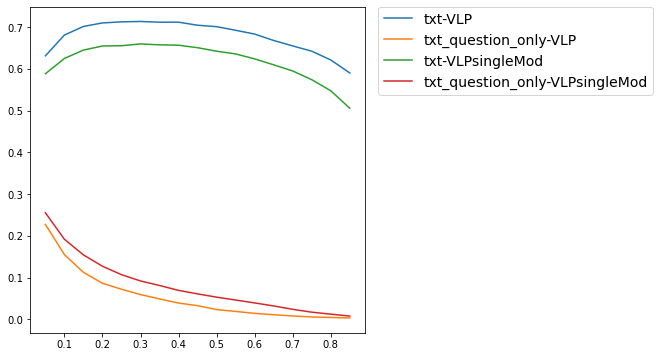

In [821]:
plt.figure(figsize=(6, 6))
for c in f1_curves:
    
    plt.plot(th_list[:-2], f1_curves[c][:-2], label=c)

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)
plt.show()

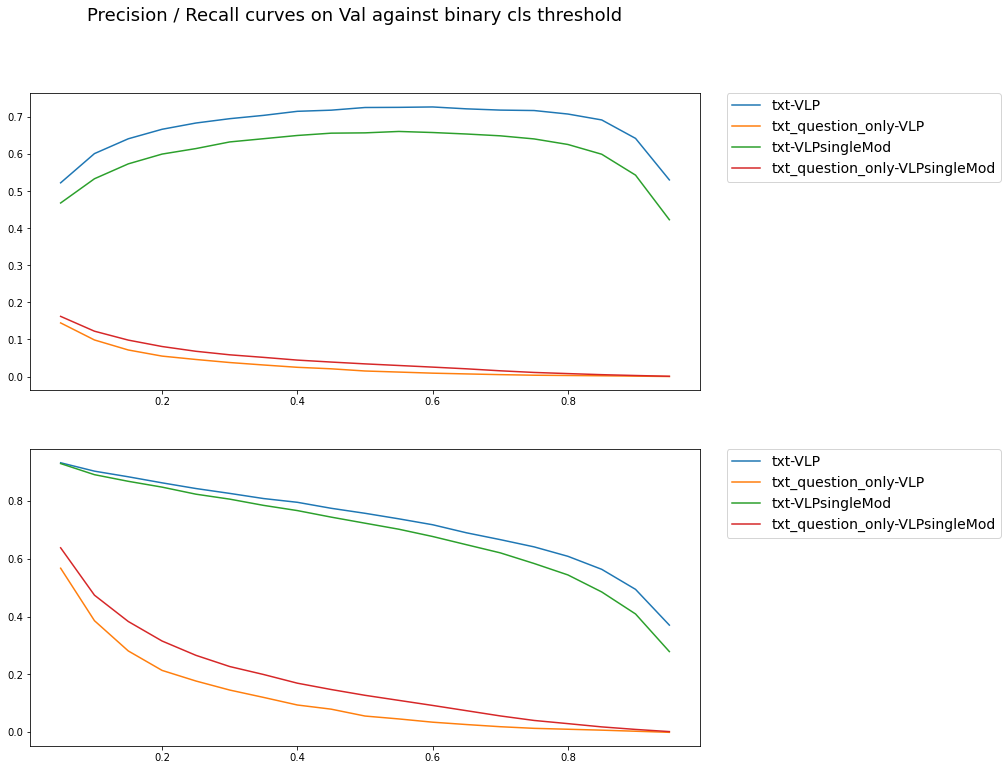

In [822]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
fig.suptitle('Precision / Recall curves on Val against binary cls threshold', fontsize=18)

for c in pr_curves:
    
    ax1.plot(th_list, pr_curves[c], label=c)
    ax1.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)
for c in re_curves:
    
    ax2.plot(th_list, re_curves[c], label=c)
    ax2.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, loc="upper left", fontsize=14)

#plt.show()

In [526]:
print(len([i for i in pred_dataset if len(pred_dataset[i]['GoldIds'])>0]))

2247


In [447]:
def extract_yes_no(s):
    for i in s.split():
        if i.lower() == 'yes' or i.lower() == 'no':
            return i.lower()
    return s

In [442]:
def extract_number(s):
    for i in s.split():
        if str(toNum(i)).isdigit():
            return toNum(i)
        try:
            return float(i)
        except: pass
    return s

/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



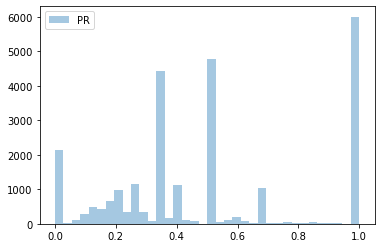

In [477]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(overlap_ratio_list, kde=False, label="PR")
plt.legend()

In [54]:
import pandas as pd

In [128]:
for k in dataset_J_fix_dis:
    if '14 Market Square in Knoxville' in dataset_J_fix_dis[k]['A']:
        pprint(dataset_J_fix_dis[k])

{'A': '"14 Market Square in Knoxville"',
 'DistractorIds': ['10302658',
                   '10320792',
                   '10135988',
                   '10320787',
                   '10320801',
                   '10320783',
                   '00019626',
                   '10302657',
                   '10302660',
                   '10302662',
                   '10135989',
                   '10320786',
                   '10320789',
                   '10320784',
                   '10320790',
                   '10302655',
                   '10320800',
                   '10302659',
                   '10320785',
                   '10320794',
                   '10302653',
                   '10320793',
                   '10302654',
                   '10302650',
                   '10320795',
                   '10138310',
                   '10302651',
                   '10302661',
                   '10138309',
                   '10320799',
                   '10302652'

In [57]:
df = pd.read_csv("/home/yingshac/CYS/WebQnA/VinVL/tmp/img.tsv", header=None)
df.head()

,0
0,"0\t{""image_id"": 1}\t/9j/4AAQSkZJRgABAQAAAQABAA..."
1,"1\t{""image_id"": 2}\t/9j/4AAQSkZJRgABAQAAAQABAA..."
2,"2\t{""image_id"": 3}\t/9j/4Rv+RXhpZgAASUkqAAgAAA..."
3,"3\t{""image_id"": 4}\t/9j/4AAQSkZJRgABAgEAkACQAA..."
4,"4\t{""image_id"": 5}\t/9j/4AAQSkZJRgABAQAAAQABAA..."


In [64]:
datum = df.iloc[1, 0]

In [59]:
print(type(datum))

<class 'str'>


In [65]:
datum#.split('\t')

'1\t{"image_id": 2}\t/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAJYAyADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD2mxsbM6fbH7LB/ql/5Zj0FWfsNn/z6wf9+xTbEf8AEvtv+uS/yFWKAIfsNn/z6wf9+xS/YbP/AJ9IP+/YqaigCL7DZ/8APrB/37H+FH2Gz/59IP8Av2KmooAi+wWf/PpB/wB+xR9gs/8An0g/79i

In [ ]:
'''
https://penzhanwu2.blob.core.windows.net/sgg/sgg_benchmark/vinvl_model_zoo/VG-SGG-dicts-vgoi6-clipped.json
https://penzhanwu2.blob.core.windows.net/sgg/sgg_benchmark/vinvl_model_zoo/vinvl_vg_x152c4.pth
https://biglmdiag.blob.core.windows.net/vinvl/model_ckpts/od_models/FourSets/config.yaml
https://biglmdiag.blob.core.windows.net/vinvl/model_ckpts/od_models/FourSets/vgcocooiobjects_v1_class2ind.json
https://biglmdiag.blob.core.windows.net/vinvl/model_ckpts/od_models/FourSets/coco_vgoiv6_class2ind.json
https://biglmdiag.blob.core.windows.net/vinvl/model_ckpts/od_models/FourSets/object365_vgoiv6_class2ind.json
https://biglmdiag.blob.core.windows.net/vinvl/model_ckpts/od_models/FourSets/oi_vgoiv6_class2ind.json
https://biglmdiag.blob.core.windows.net/vinvl/model_ckpts/od_models/objects365/attr_frcnn_X152C4.yaml
https://biglmdiag.blob.core.windows.net/vinvl/model_ckpts/od_models/objects365/model_0740000.pth
https://biglmdiag.blob.core.windows.net/vinvl/model_ckpts/od_models/objects365/train.labelmap.tsv
'''

In [15]:
x = torch.zeros((5,4))
x[[],[1,3]].size()

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [0], [2]